# QMSS Thesis Code
## Cara Feldkamp

In [1]:
import numpy as np
import pandas as pd
import json
import time
from pytimeparse.timeparse import timeparse
import datetime
import statsmodels.api as sm
import random
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import PCA 
from sklearn.preprocessing import StandardScaler, normalize 
from sklearn.metrics import silhouette_score 
import scipy.cluster.hierarchy as shc 
from matplotlib import pyplot
from stargazer.stargazer import Stargazer
from IPython.core.display import HTML
from statsmodels.iolib.summary2 import summary_col
from statsmodels.compat import lzip
from statsmodels.stats.outliers_influence import variance_inflation_factor
sns.set()
random.seed(999)

# Data cleaning

### World Bank Governance Indicators

In [2]:
wb_governance_indicators = pd.read_csv('/Users/carafeldkamp/Downloads/World_Bank_Governance_Indicators.csv', encoding='latin-1', sep=',')


### World Bank Development Indicators

In [3]:
econ_data = pd.read_csv('/Users/carafeldkamp/Downloads/WDI.csv',encoding='latin-1', sep=',')

In [4]:
econ_data = econ_data[['Country Name','Country Code','Indicator Name','Indicator Code','2011','2012','2013','2014','2015','2016','2017','2018']]

In [5]:
econ_data.loc[econ_data['Country Name']=='Cabo Verde','Country Name'] = 'Cape Verde'
econ_data.loc[econ_data['Country Name']=="Cote d'Ivoire",'Country Name'] = "Côte d'Ivoire"
econ_data.loc[econ_data['Country Name']=='North Macedonia','Country Name'] = 'Macedonia, FYR'

In [6]:
econ_data = pd.melt(econ_data, id_vars =['Country Name','Country Code','Indicator Name','Indicator Code'], value_vars =['2011','2012','2013','2014','2015','2016','2017','2018'], var_name = 'Year',value_name = 'Value')

In [7]:
econ_indicators = econ_data.pivot_table(index = ['Country Name','Country Code','Year'],columns='Indicator Name',values = 'Value')

In [8]:
#Not all indicators are reported every year.  Here I'm filling in nan values with means by country
econ_indicators = econ_indicators.fillna(econ_indicators.groupby('Country Name').transform('mean'))
econ_indicators = econ_indicators.reset_index()

In [9]:
matcher = pd.DataFrame(wb_governance_indicators[['Year','Country_Match','WB_Country']])
econ_indicators['Year'] = econ_indicators['Year'].astype(int)
econ_indicators['Est_Internet_Users'] = (econ_indicators['Individuals using the Internet (% of population)']/100)*econ_indicators['Population, total']
econ_indicators = pd.merge(econ_indicators, matcher, how='inner',left_on=['Country Name','Year'],right_on=['WB_Country','Year'])

### Press Freedom Index

In [10]:
press_freedom_index = pd.read_csv('/Users/carafeldkamp/Downloads/RSF_Press_Freedom_Index_Data_Formatted.csv', encoding='latin-1', sep=',')


In [11]:
#rescaling scores so that higher score = better governance/more freedom
press_freedom_index.iloc[:,2] = press_freedom_index.iloc[:,2].apply(lambda x: x * (-1))

### Freedom House Scores

In [12]:
fh_scores = pd.read_csv('/Users/carafeldkamp/Downloads/Freedom_House_Scores.csv', encoding='latin-1', sep=',')
#higher score = more freedom

### Twitter Removal Requests

In [13]:
twitter_2019_1 = pd.read_csv('/Users/carafeldkamp/Downloads/removal-requests-report-jan-jun-2019.csv',encoding='latin-1', sep=',')
twitter_2018_2 = pd.read_csv('/Users/carafeldkamp/Downloads/removal-requests-report-jul-dec-2018.csv',encoding='latin-1', sep=',')
twitter_2018_1 = pd.read_csv('/Users/carafeldkamp/Downloads/removal-requests-report-jan-jun-2018.csv', encoding='latin-1', sep=',')
twitter_2017_2 = pd.read_csv('/Users/carafeldkamp/Downloads/removal-requests-report-jul-dec-2017.csv', encoding='latin-1', sep=',')
twitter_2017_1 = pd.read_csv('/Users/carafeldkamp/Downloads/removal-requests-report-jan-jun-2017.csv', encoding='latin-1', sep=',')
twitter_2016_2 = pd.read_csv('/Users/carafeldkamp/Downloads/removal-requests-report-jul-dec-2016.csv', encoding='latin-1', sep=',')
twitter_2016_1 = pd.read_csv('/Users/carafeldkamp/Downloads/removal-requests-report-jan-jun-2016.csv', encoding='latin-1', sep=',')
twitter_2015_2 = pd.read_csv('/Users/carafeldkamp/Downloads/removal-requests-report-jul-dec-2015.csv', encoding='latin-1', sep=',')
twitter_2015_1 = pd.read_csv('/Users/carafeldkamp/Downloads/removal-requests-report-jan-jun-2015.csv', encoding='latin-1', sep=',')
twitter_2014_2 = pd.read_csv('/Users/carafeldkamp/Downloads/removal-requests-report-jul-dec-2014.csv', encoding='latin-1', sep=',')
twitter_2014_1 = pd.read_csv('/Users/carafeldkamp/Downloads/removal-requests-report-jan-jun-2014.csv', encoding='latin-1', sep=',')
twitter_2013_2 = pd.read_csv('/Users/carafeldkamp/Downloads/removal-requests-report-jul-dec-2013.csv', encoding='latin-1', sep=',')
twitter_2013_1 = pd.read_csv('/Users/carafeldkamp/Downloads/removal-requests-report-jan-jun-2013.csv', encoding='latin-1', sep=',')
twitter_2012_2 = pd.read_csv('/Users/carafeldkamp/Downloads/removal-requests-report-jul-dec-2012.csv', encoding='latin-1', sep=',')
twitter_2012_1 = pd.read_csv('/Users/carafeldkamp/Downloads/removal-requests-report-jan-jun-2012.csv', encoding='latin-1', sep=',')

In [14]:
def clean_data(orig_df, year, first_or_second):
    
    clean_df = pd.DataFrame()
    
    clean_df['COUNTRY'] = orig_df['COUNTRY']
    
    clean_df['REMOVAL REQUESTS (COURT ORDERS)'] = [float(str(i).replace('-','0').replace(',','')) for i in orig_df['REMOVAL REQUESTS (COURT ORDERS)']]
    clean_df['REMOVAL REQUESTS (GOVT AGENCY, POLICE, OTHER)'] = [float(str(i).replace('-','0').replace(',','')) for i in orig_df['GOVT']]
    
    clean_df['TOTAL_REQUESTS'] = clean_df['REMOVAL REQUESTS (COURT ORDERS)'] + clean_df['REMOVAL REQUESTS (GOVT AGENCY, POLICE, OTHER)']
    
    clean_df['PCT_WITHHELD'] = [float(str(i).replace('-','0').replace('%',''))/100 for i in orig_df['PERCENTAGE WHERE SOME CONTENT WITHHELD']]
    
    clean_df['REQUESTS_WITH_REMOVALS'] = clean_df['TOTAL_REQUESTS'] * clean_df['PCT_WITHHELD']
    clean_df['ACCOUNTS_SPECIFIED'] = [float(str(i).replace('-','0').replace(',','')) for i in orig_df['ACCOUNTS SPECIFIED']]
    clean_df['ACCOUNTS_WITHHELD'] = [float(str(i).replace('-','0').replace(',','')) for i in orig_df['ACCOUNTS WITHHELD']]     
    clean_df['TWEETS_WITHHELD'] = [float(str(i).replace('-','0').replace(',','')) for i in orig_df['TWEETS WITHHELD']]
    clean_df['ACCOUNTS_TOS'] = [float(str(i).replace('-','0').replace(',','')) for i in orig_df['ACCOUNTS (TOS)']]
    clean_df['YEAR'] = year
    clean_df = clean_df[clean_df['COUNTRY']!='Total']
    clean_df = clean_df[clean_df['COUNTRY']!='TOTAL']
    
    clean_df = clean_df.loc[:,['COUNTRY','TOTAL_REQUESTS','REQUESTS_WITH_REMOVALS','ACCOUNTS_SPECIFIED','ACCOUNTS_WITHHELD','TWEETS_WITHHELD','ACCOUNTS_TOS','YEAR']]
    
    new_df = clean_df
    return new_df
    
    print('Done!')


In [15]:
#fixing characters and inconsistencies in column name

twitter_2019_1['GOVT'] = twitter_2019_1['REMOVAL REQUESTS (GOVT AGENCY, POLICE, OTHER)']
twitter_2018_2['GOVT'] = twitter_2018_2['REMOVAL REQUESTS (GOVT AGENCY, POLICE, OTHER)']
twitter_2018_1['GOVT'] = twitter_2018_1['REMOVAL REQUESTS (GOVT AGENCY, POLICE, OTHER)']
twitter_2017_2['GOVT'] = twitter_2017_2.iloc[:,4]
twitter_2017_1['GOVT'] = twitter_2017_1.iloc[:,4]
twitter_2016_2['GOVT'] = twitter_2016_2['REMOVAL REQUESTS (GOVäó»T AGENCY, POLICE, OTHER)']
twitter_2016_1['GOVT'] = twitter_2016_1['REMOVAL REQUESTS (GOVâT AGENCY, POLICE, OTHER)'] 
twitter_2015_2['GOVT'] = twitter_2015_2['REMOVAL REQUESTS (GOVâT AGENCY, POLICE, OTHER)']
twitter_2015_1['GOVT'] = twitter_2015_1['REMOVAL REQUESTS (GOVâT AGENCY, POLICE, OTHER)']
twitter_2014_2['GOVT'] = twitter_2014_2['REMOVAL REQUESTS (GOVâT AGENCY, POLICE, OTHER)']
twitter_2014_1['GOVT'] = twitter_2014_1['REMOVAL REQUESTS (GOVâT AGENCY, POLICE, OTHER)']
twitter_2013_2['GOVT'] = twitter_2013_2['REMOVAL REQUESTS (GOVâT AGENCY, POLICE, OTHER)']
twitter_2013_1['GOVT'] = twitter_2013_1['REMOVAL REQUESTS (GOVâT AGENCY, POLICE, OTHER)']
twitter_2012_2['GOVT'] = twitter_2012_2['REMOVAL REQUESTS (GOVâT AGENCY, POLICE, OTHER)']
twitter_2012_1['GOVT'] = twitter_2012_1['REMOVAL REQUESTS (GOVâT AGENCY, POLICE, OTHER)']


In [16]:
tw_2019_1 = clean_data(twitter_2019_1, 2019, 1)
tw_2018_2 = clean_data(twitter_2018_2, 2018, 2)
tw_2018_1 = clean_data(twitter_2018_1, 2018, 1)
tw_2017_2 = clean_data(twitter_2017_2, 2017, 2)
tw_2017_1 = clean_data(twitter_2017_1, 2017, 1)
tw_2016_2 = clean_data(twitter_2016_2, 2016, 2)
tw_2016_1 = clean_data(twitter_2016_1, 2016, 1)
tw_2015_2 = clean_data(twitter_2015_2, 2015, 2)
tw_2015_1 = clean_data(twitter_2015_1, 2015, 1)
tw_2014_2 = clean_data(twitter_2014_2, 2014, 2)
tw_2014_1 = clean_data(twitter_2014_1, 2014, 1)
tw_2013_2 = clean_data(twitter_2013_2, 2013, 2)
tw_2013_1 = clean_data(twitter_2013_1, 2013, 1)
tw_2012_2 = clean_data(twitter_2012_2, 2012, 2)
tw_2012_1 = clean_data(twitter_2012_1, 2012, 1)

In [17]:
tw_2017_1 = tw_2017_1.loc[tw_2017_1.COUNTRY.isna() == False,:]

In [18]:
tw_2012_1['Timeframe'] = 'H1'
tw_2012_2['Timeframe'] = 'H2'
tw_2013_1['Timeframe'] = 'H1'
tw_2013_2['Timeframe'] = 'H2'
tw_2014_1['Timeframe'] = 'H1'
tw_2014_2['Timeframe'] = 'H2'
tw_2015_1['Timeframe'] = 'H1'
tw_2015_2['Timeframe'] = 'H2'
tw_2016_1['Timeframe'] = 'H1'
tw_2016_2['Timeframe'] = 'H2'
tw_2017_1['Timeframe'] = 'H1'
tw_2017_2['Timeframe'] = 'H2'
tw_2018_1['Timeframe'] = 'H1'
tw_2018_2['Timeframe'] = 'H2'
tw_2019_1['Timeframe'] = 'H1'

In [19]:
twitter_granular = pd.concat([tw_2012_1,tw_2012_2,tw_2013_1,tw_2013_2,tw_2014_1,tw_2014_2,tw_2015_1,tw_2015_2,tw_2016_1,tw_2016_2,tw_2017_1,tw_2017_2,tw_2018_1,tw_2018_2,tw_2019_1])

In [20]:
twitter_granular.loc[twitter_granular['COUNTRY'] == 'Tunisla',['COUNTRY']] = 'Tunisia'
twitter_granular.loc[twitter_granular['COUNTRY'] == 'Crotia',['COUNTRY']] = 'Croatia'
twitter_granular.loc[twitter_granular['COUNTRY'] == 'Czech Republuc',['COUNTRY']] = 'Czech Republic'
twitter_granular.loc[twitter_granular['COUNTRY'] == 'Luxemburg',['COUNTRY']] = 'Luxembourg'
twitter_granular.loc[twitter_granular['COUNTRY'] == 'Czech Republuc',['COUNTRY']] = 'Czech Republic'
twitter_granular.loc[twitter_granular['COUNTRY'] == 'Luxemburg',['COUNTRY']] = 'Luxembourg'

In [21]:
#Twitter data by 6 month intervals
twitter_granular.columns = ['Country_Match','tw_removal_requests','tw_successful_requests','tw_accounts_specified','tw_accounts_withheld','tw_tweets_withheld','tw_accounts_tos','Year','Timeframe']


In [22]:
def tw_combine(input1, input2):
    output_df = pd.DataFrame()
    output_df = pd.merge(input1, input2, how = 'outer', on = ['COUNTRY','YEAR'])
    output_df.fillna(0, inplace=True)
    output_df['TOTAL_REQUESTS'] = output_df['TOTAL_REQUESTS_x'] + output_df['TOTAL_REQUESTS_y']
    output_df['REQUESTS_WITH_REMOVALS'] = output_df['REQUESTS_WITH_REMOVALS_x'] + output_df['REQUESTS_WITH_REMOVALS_y']
    output_df['ACCOUNTS_SPECIFIED'] = output_df['ACCOUNTS_SPECIFIED_x'] + output_df['ACCOUNTS_SPECIFIED_y']
    output_df['ACCOUNTS_WITHHELD'] = output_df['ACCOUNTS_WITHHELD_x'] + output_df['ACCOUNTS_WITHHELD_y']
    output_df['TWEETS_WITHHELD'] = output_df['TWEETS_WITHHELD_x'] + output_df['TWEETS_WITHHELD_y']
    output_df['ACCOUNTS_TOS'] = output_df['ACCOUNTS_TOS_x'] + output_df['ACCOUNTS_TOS_y']
    output_df = output_df.loc[:,['COUNTRY','TOTAL_REQUESTS','REQUESTS_WITH_REMOVALS','ACCOUNTS_SPECIFIED','ACCOUNTS_WITHHELD','TWEETS_WITHHELD','ACCOUNTS_TOS','YEAR']]
    
    combo_df = output_df
    return combo_df

    print("Done!")


In [23]:
tw_2018 = tw_combine(tw_2018_2,tw_2018_1)
tw_2017 = tw_combine(tw_2017_2,tw_2017_1)
tw_2016 = tw_combine(tw_2016_2,tw_2016_1)
tw_2015 = tw_combine(tw_2015_2,tw_2015_1)
tw_2014 = tw_combine(tw_2014_2,tw_2014_1)
tw_2013 = tw_combine(tw_2013_2,tw_2013_1)
tw_2012 = tw_combine(tw_2012_2,tw_2012_1)

In [24]:
tw_formatted = pd.concat([tw_2012,tw_2013,tw_2014,tw_2015,tw_2016,tw_2017,tw_2018])

In [25]:
tw_formatted.loc[tw_formatted['COUNTRY'] == 'Tunisla',['COUNTRY']] = 'Tunisia'
tw_formatted.loc[tw_formatted['COUNTRY'] == 'Crotia',['COUNTRY']] = 'Croatia'
tw_formatted.loc[tw_formatted['COUNTRY'] == 'Czech Republuc',['COUNTRY']] = 'Czech Republic'
tw_formatted.loc[tw_formatted['COUNTRY'] == 'Luxemburg',['COUNTRY']] = 'Luxembourg'
tw_formatted = tw_formatted[tw_formatted['COUNTRY']!="TOTALS"]

tw_formatted.columns = ['tw_country','tw_removal_requests','tw_successful_requests','tw_accounts_specified','tw_accounts_tos','tw_accounts_withheld','tw_tweets_withheld','Year']

### Facebook Withheld Posts and Internet Disruptions

In [26]:
fb_2019_H2 = pd.read_csv('/Users/carafeldkamp/Downloads/ContentRestrictions/ContentRestrictions-2019_H2.csv',encoding='latin-1', sep=',')
fb_2019_H1 = pd.read_csv('/Users/carafeldkamp/Downloads/ContentRestrictions/ContentRestrictions-2019_H1.csv',encoding='latin-1', sep=',')
fb_2018_H2 = pd.read_csv('/Users/carafeldkamp/Downloads/ContentRestrictions/ContentRestrictions-2018_H2.csv',encoding='latin-1', sep=',')
fb_2018_H1 = pd.read_csv('/Users/carafeldkamp/Downloads/ContentRestrictions/ContentRestrictions-2018_H1.csv',encoding='latin-1', sep=',')
fb_2017_H2 = pd.read_csv('/Users/carafeldkamp/Downloads/ContentRestrictions/ContentRestrictions-2017_H2.csv',encoding='latin-1', sep=',')
fb_2017_H1 = pd.read_csv('/Users/carafeldkamp/Downloads/ContentRestrictions/ContentRestrictions-2017_H1.csv',encoding='latin-1', sep=',')
fb_2016_H2 = pd.read_csv('/Users/carafeldkamp/Downloads/ContentRestrictions/ContentRestrictions-2016_H2.csv',encoding='latin-1', sep=',')
fb_2016_H1 = pd.read_csv('/Users/carafeldkamp/Downloads/ContentRestrictions/ContentRestrictions-2016_H1.csv',encoding='latin-1', sep=',')
fb_2015_H2 = pd.read_csv('/Users/carafeldkamp/Downloads/ContentRestrictions/ContentRestrictions-2015_H2.csv',encoding='latin-1', sep=',')
fb_2015_H1 = pd.read_csv('/Users/carafeldkamp/Downloads/ContentRestrictions/ContentRestrictions-2015_H1.csv',encoding='latin-1', sep=',')
fb_2014_H2 = pd.read_csv('/Users/carafeldkamp/Downloads/ContentRestrictions/ContentRestrictions-2014_H2.csv',encoding='latin-1', sep=',')
fb_2014_H1 = pd.read_csv('/Users/carafeldkamp/Downloads/ContentRestrictions/ContentRestrictions-2014_H1.csv',encoding='latin-1', sep=',')
fb_2013_H2 = pd.read_csv('/Users/carafeldkamp/Downloads/ContentRestrictions/ContentRestrictions-2013_H2.csv',encoding='latin-1', sep=',')


In [27]:
fb_2019_H2['Year'] = 2019
fb_2019_H1['Year'] = 2019
fb_2018_H2['Year'] = 2018
fb_2018_H1['Year'] = 2018
fb_2017_H2['Year'] = 2017
fb_2017_H1['Year'] = 2017
fb_2016_H2['Year'] = 2016
fb_2016_H1['Year'] = 2016
fb_2015_H2['Year'] = 2015
fb_2015_H1['Year'] = 2015
fb_2014_H2['Year'] = 2014
fb_2014_H1['Year'] = 2014
fb_2013_H2['Year'] = 2013

fb_2019_H2['Timeframe'] = "H2"
fb_2019_H1['Timeframe'] = "H1"
fb_2018_H2['Timeframe'] = "H2"
fb_2018_H1['Timeframe'] = "H1"
fb_2017_H2['Timeframe'] = "H2"
fb_2017_H1['Timeframe'] = "H1"
fb_2016_H2['Timeframe'] = "H2"
fb_2016_H1['Timeframe'] = "H1"
fb_2015_H2['Timeframe'] = "H2"
fb_2015_H1['Timeframe'] = "H1"
fb_2014_H2['Timeframe'] = "H2"
fb_2014_H1['Timeframe'] = "H1"
fb_2013_H2['Timeframe'] = "H2"

In [28]:
fb_removal_requests = pd.merge(fb_2019_H2,fb_2019_H1, how='outer',on=['Country','count','Year','Timeframe'])
fb_removal_requests = pd.merge(fb_removal_requests,fb_2018_H2, how='outer',on=['Country','count','Year','Timeframe'])
fb_removal_requests = pd.merge(fb_removal_requests,fb_2018_H1, how='outer',on=['Country','count','Year','Timeframe'])
fb_removal_requests = pd.merge(fb_removal_requests,fb_2017_H2, how='outer',on=['Country','count','Year','Timeframe'])
fb_removal_requests = pd.merge(fb_removal_requests,fb_2017_H1, how='outer',on=['Country','count','Year','Timeframe'])
fb_removal_requests = pd.merge(fb_removal_requests,fb_2016_H2, how='outer',on=['Country','count','Year','Timeframe'])
fb_removal_requests = pd.merge(fb_removal_requests,fb_2016_H1, how='outer',on=['Country','count','Year','Timeframe'])
fb_removal_requests = pd.merge(fb_removal_requests,fb_2015_H2, how='outer',on=['Country','count','Year','Timeframe'])
fb_removal_requests = pd.merge(fb_removal_requests,fb_2015_H1, how='outer',on=['Country','count','Year','Timeframe'])
fb_removal_requests = pd.merge(fb_removal_requests,fb_2014_H2, how='outer',on=['Country','count','Year','Timeframe'])
fb_removal_requests = pd.merge(fb_removal_requests,fb_2014_H1, how='outer',on=['Country','count','Year','Timeframe'])
fb_removal_requests = pd.merge(fb_removal_requests,fb_2013_H2, how='outer',on=['Country','count','Year','Timeframe'])

In [29]:
fb_removal_requests['Country_Match'] = fb_removal_requests['Country']
fb_removal_requests.loc[fb_removal_requests['Country_Match']=='Ivory Coast','Country_Match'] = "Cote d'Ivoire"
fb_removal_requests['FB_Withheld_Count'] = fb_removal_requests['count']

In [30]:
fb_by_year = fb_removal_requests.groupby(['Country_Match','Year']).sum().reset_index().sort_values(by=['Year','Country_Match'])
fb_by_year = fb_by_year.drop(['count','Unnamed: 2'],axis=1)

In [31]:
#fb_by_year

In [32]:
#Intentional disruptions of Facebook and/or internet service
sd_2019_H2 = pd.read_csv('/Users/carafeldkamp/Downloads/Internet_Disruptions/Internet_Disruptions-2019-H2.csv',encoding='latin-1', sep=',')
sd_2019_H1 = pd.read_csv('/Users/carafeldkamp/Downloads/Internet_Disruptions/Internet_Disruptions-2019-H1.csv',encoding='latin-1', sep=',')
sd_2018_H2 = pd.read_csv('/Users/carafeldkamp/Downloads/Internet_Disruptions/Internet_Disruptions-2018-H2.csv',encoding='latin-1', sep=',')
sd_2018_H1 = pd.read_csv('/Users/carafeldkamp/Downloads/Internet_Disruptions/Internet_Disruptions-2018-H1.csv',encoding='latin-1', sep=',')
sd_2017_H2 = pd.read_csv('/Users/carafeldkamp/Downloads/Internet_Disruptions/Internet_Disruptions-2017-H2.csv',encoding='latin-1', sep=',')
sd_2017_H1 = pd.read_csv('/Users/carafeldkamp/Downloads/Internet_Disruptions/Internet_Disruptions-2017-H1.csv',encoding='latin-1', sep=',')
sd_2016_H2 = pd.read_csv('/Users/carafeldkamp/Downloads/Internet_Disruptions/Internet_Disruptions-2016-H2.csv',encoding='latin-1', sep=',',parse_dates=[0,1])



In [33]:
sd_2019_H2['start_time'] = pd.to_datetime(sd_2019_H2['start_time'].astype(str))
sd_2019_H2['end_time'] = sd_2019_H2['end_time'].astype(str)
sd_2019_H2.loc[sd_2019_H2['end_time']=='Ongoing','end_time'] = '2019-12-31T00:00:00'
sd_2019_H2['end_time'] = pd.to_datetime(sd_2019_H2['end_time'])

sd_2019_H1['start_time'] = pd.to_datetime(sd_2019_H1['start_time'].astype(str))
sd_2019_H1['end_time'] = sd_2019_H1['end_time'].astype(str)
sd_2019_H1.loc[sd_2019_H1['end_time']=='Ongoing','end_time'] = '2019-07-01T00:00:00'
sd_2019_H1['end_time'] = pd.to_datetime(sd_2019_H1['end_time'])

sd_2018_H2['start_time'] = sd_2018_H2['start_time'].astype(str)
sd_2018_H2.loc[sd_2018_H2['start_time']=='Ongoing','start_time'] = '2018-07-01T00:00:00'
sd_2018_H2['start_time'] = pd.to_datetime(sd_2018_H2['start_time'])
sd_2018_H2['end_time'] = sd_2018_H2['end_time'].astype(str)
sd_2018_H2.loc[sd_2018_H2['end_time']=='Ongoing','end_time'] = '2019-01-01T00:00:00'
sd_2018_H2['end_time'] = pd.to_datetime(sd_2018_H2['end_time'])

sd_2018_H1['start_time'] = pd.to_datetime(sd_2018_H1['start_time'].astype(str))
sd_2018_H1['end_time'] = pd.to_datetime(sd_2018_H1['end_time'].astype(str))

sd_2017_H2['start_time'] = pd.to_datetime(sd_2017_H2['start_time'].astype(str))
sd_2017_H2['end_time'] = pd.to_datetime(sd_2017_H2['end_time'].astype(str))

#2017 H1 and 2016 H2 only have counts of the number of service disruptions. 
#Facebook started reporting timestamped outages after that.


In [34]:
sd_2019_H2['Outage_Time'] = sd_2019_H2['end_time'] - sd_2019_H2['start_time']
sd_2019_H1['Outage_Time'] = sd_2019_H1['end_time'] - sd_2019_H1['start_time']
sd_2018_H2['Outage_Time'] = sd_2018_H2['end_time'] - sd_2018_H2['start_time']
sd_2018_H1['Outage_Time'] = sd_2018_H1['end_time'] - sd_2018_H1['start_time']
sd_2017_H2['Outage_Time'] = sd_2017_H2['end_time'] - sd_2017_H2['start_time']

In [35]:
fb_outage_2019_H2 = pd.DataFrame(sd_2019_H2.groupby('Country').count()['region'].reset_index())

fb_temp = pd.DataFrame(sd_2019_H2.groupby('Country').Outage_Time.sum().reset_index())
fb_outage_2019_H2['Total_Outage_Time'] = fb_temp['Outage_Time']
fb_outage_2019_H2.columns = ['Country','Outages','Total_Outage_Time']

In [36]:
fb_outage_2019_H1 = pd.DataFrame(sd_2019_H1.groupby('Country').count()['region'].reset_index())

fb_temp = pd.DataFrame(sd_2019_H1.groupby('Country').Outage_Time.sum().reset_index())
fb_outage_2019_H1['Total_Outage_Time'] = fb_temp['Outage_Time']
fb_outage_2019_H1.columns = ['Country','Outages','Total_Outage_Time']


In [37]:
fb_outage_2018_H2 = pd.DataFrame(sd_2018_H2.groupby('Country').count()['region'].reset_index())

fb_temp2 = pd.DataFrame(sd_2018_H2.groupby('Country').Outage_Time.sum().reset_index())
fb_outage_2018_H2['Total_Outage_Time'] = fb_temp2['Outage_Time']
fb_outage_2018_H2.columns = ['Country','Outages','Total_Outage_Time']



In [38]:
fb_outage_2018_H1 = pd.DataFrame(sd_2018_H1.groupby('Country').count()['region'].reset_index())

fb_temp3 = pd.DataFrame(sd_2018_H1.groupby('Country').Outage_Time.sum().reset_index())
fb_outage_2018_H1['Total_Outage_Time'] = fb_temp3['Outage_Time']
fb_outage_2018_H1.columns = ['Country','Outages','Total_Outage_Time']


In [39]:
fb_outage_2017_H2 = pd.DataFrame(sd_2017_H2.groupby('Country').count()['region'].reset_index())

fb_temp4 = pd.DataFrame(sd_2017_H2.groupby('Country').Outage_Time.sum().reset_index())
fb_outage_2017_H2['Total_Outage_Time'] = fb_temp4['Outage_Time']
fb_outage_2017_H2.columns = ['Country','Outages','Total_Outage_Time']


In [40]:
sd_2017_H1.columns = ['Country','Outages']
sd_2016_H2.columns = ['Country','Outages']

In [41]:
#Filling in Outage times with the min outage time in 2017 HD2 (is similar to the means for 2018 H1 and H2).
#Mean is thrown off by outlier Cameroon, and would have resulted in overestimating for the other countries, 
    #so I used the min for a more conservative estimate
#There is an outage marked as 00:00:00 time, so I'm taking the second smallest value, which is 01:30:00

sd_2017_H1['Total_Outage_Time'] = sd_2017_H2.loc[5,'Outage_Time']*sd_2017_H1['Outages']

sd_2016_H2['Outages'] = sd_2016_H2['Outages'].astype(int)
sd_2016_H2['Total_Outage_Time'] = sd_2017_H2.loc[5,'Outage_Time']*sd_2016_H2['Outages']

In [42]:
#Fixing negative value
sd_2018_H2.iloc[23,4] = sd_2018_H2.iloc[23,4]*-1

In [43]:
fb_outage_2019_H2['Year'] = 2019
fb_outage_2019_H2['Timeframe'] = 'H2'

fb_outage_2019_H1['Year'] = 2019
fb_outage_2019_H1['Timeframe'] = 'H1'

fb_outage_2018_H2['Year'] = 2018
fb_outage_2018_H2['Timeframe'] = 'H2'

fb_outage_2018_H1['Year'] = 2018
fb_outage_2018_H1['Timeframe'] = 'H1'

fb_outage_2017_H2['Year'] = 2017
fb_outage_2017_H2['Timeframe'] = 'H2'

fb_outage_2017_H1 = sd_2017_H1
fb_outage_2017_H1['Year'] = 2017
fb_outage_2017_H1['Timeframe'] = 'H1'

fb_outage_2016_H2 = sd_2016_H2
fb_outage_2016_H2['Year'] = 2016
fb_outage_2016_H2['Timeframe'] = 'H2'

In [44]:
fb_outages = pd.merge(fb_outage_2019_H2,fb_outage_2019_H1, how='outer',on=['Country','Outages','Total_Outage_Time','Year','Timeframe'])
fb_outages = pd.merge(fb_outages,fb_outage_2018_H2, how='outer',on=['Country','Outages','Total_Outage_Time','Year','Timeframe'])
fb_outages = pd.merge(fb_outages,fb_outage_2018_H1, how='outer',on=['Country','Outages','Total_Outage_Time','Year','Timeframe'])
fb_outages = pd.merge(fb_outages,fb_outage_2017_H2, how='outer',on=['Country','Outages','Total_Outage_Time','Year','Timeframe'])
fb_outages = pd.merge(fb_outages,fb_outage_2017_H1, how='outer',on=['Country','Outages','Total_Outage_Time','Year','Timeframe'])
fb_outages = pd.merge(fb_outages,fb_outage_2016_H2, how='outer',on=['Country','Outages','Total_Outage_Time','Year','Timeframe'])


In [45]:
fb_granular = pd.merge(fb_removal_requests,fb_outages, how="outer",on=['Country','Year','Timeframe'])


In [46]:
fb_granular['Country_Match'] = fb_granular['Country']
fb_granular = fb_granular.drop(['count','Country'],axis=1)

In [47]:
fb_outages_by_year = pd.DataFrame(fb_outages.groupby(['Country','Year']).Total_Outage_Time.sum())


In [48]:
fb_outages_by_year = fb_outages_by_year.reset_index()


In [49]:
fb_outages_by_year['Total_FB_Outage_Time'] = fb_outages_by_year['Total_Outage_Time'] 
fb_outages_by_year = fb_outages_by_year.drop(['Total_Outage_Time'], axis=1)

In [50]:
#fb_outages_by_year.sort_values(by='Total_FB_Outage_Time', ascending=False)

### Google Removal Request Data

In [51]:
google_agg = pd.read_csv('/Users/carafeldkamp/Downloads/google-government-removals_dec2019/google-government-removal-requests.csv',encoding='latin-1', sep=',')
google_detailed = pd.read_csv('/Users/carafeldkamp/Downloads/google-government-removals_dec2019/google-government-detailed-removal-requests.csv',encoding='latin-1', sep=',')

#google_agg.head()
#google_detailed.head()

In [52]:
google_agg['Period Ending'] = pd.to_datetime(google_agg['Period Ending'].astype(str))
google_detailed['Period Ending'] = pd.to_datetime(google_detailed['Period Ending'].astype(str))

In [53]:
google_agg['Year'] = [x.year for x in google_agg['Period Ending']]
google_agg['Timeframe'] = [x.month for x in google_agg['Period Ending']]

google_detailed['Year'] = [x.year for x in google_detailed['Period Ending']]
google_detailed['Timeframe'] = [x.month for x in google_detailed['Period Ending']]

In [54]:
google_agg.loc[google_agg['Timeframe']==12,'Timeframe'] = "H2"
google_agg.loc[google_agg['Timeframe']==6,'Timeframe'] = "H1"

google_detailed.loc[google_detailed['Timeframe']==12,'Timeframe'] = "H2"
google_detailed.loc[google_detailed['Timeframe']==6,'Timeframe'] = "H1"

In [55]:
google_reasons = pd.DataFrame(google_detailed.groupby(['Year','Timeframe','Country', 'Reason'])['Court Orders','Executive, Police, etc.','Items Requested To Be Removed'].sum().reset_index())
#google_reasons.head()

In [56]:
google_reasons['Google_Total_Requests'] = google_reasons['Court Orders'] + google_reasons['Executive, Police, etc.']


In [57]:
#Data is incomplete/inconsistent for the reporting periods in 2009 and 2010, so I'm removing those
google_agg = google_agg.loc[google_agg['Year']>2010, :]

In [58]:
#Data is also not reported for China, so removing those rows because they say "?"
google_agg = google_agg.loc[google_agg['All Requests: % Fully Or Partially Complied With']!='?',:]

In [59]:
google_removal_requests = google_agg

In [60]:
google_removal_requests['Google_Items_Requested_for_Removal'] = google_removal_requests['All Requests: Items Requested To Be Removed'].astype(float)


In [61]:
#Need to recalculate compliance rates by year, instead of by 6-month period
google_removal_requests['All Requests: % Fully Or Partially Complied With'] = google_removal_requests['All Requests: % Fully Or Partially Complied With'].astype(float)/100.00


In [62]:
google_removal_requests['All Requests: Number of Requests'] = google_removal_requests['All Requests: Number of Requests'].astype(float)


In [63]:
google_removal_requests['Google_Requests_Complied_With'] = google_removal_requests['All Requests: Number of Requests'] * google_removal_requests['All Requests: % Fully Or Partially Complied With']


In [64]:
google_granular = google_removal_requests
google_granular['google_compliance_rate'] = google_granular['All Requests: % Fully Or Partially Complied With']
google_granular['google_removal_requests'] = google_granular['All Requests: Number of Requests']
google_granular['Country_Match'] = google_granular['Country']
google_granular = google_granular.drop(['All Requests: Number of Requests','All Requests: % Fully Or Partially Complied With','CLDR Territory Code','Period Ending','Country'],axis=1)


In [65]:
google_by_year = pd.DataFrame(google_removal_requests.groupby(['Country','Year']).sum().reset_index())
google_by_year = google_by_year.loc[:,['Country','Year','All Requests: Number of Requests','Google_Items_Requested_for_Removal','Google_Requests_Complied_With']]
                                                                         

In [66]:
google_by_year['Google_Compliance_Rate'] = (google_by_year['Google_Requests_Complied_With']/google_by_year['All Requests: Number of Requests'])*100


In [67]:
google_by_year['Google_Removal_Requests'] = google_by_year['All Requests: Number of Requests']
google_by_year = google_by_year.drop(['All Requests: Number of Requests'],axis=1)

In [68]:
#google_by_year.head()

In [69]:
#google_reasons.to_csv('/Users/carafeldkamp/Documents/google_reasons.csv')

# Combining Data

In [70]:
joined_data = pd.merge(econ_indicators, wb_governance_indicators, how='outer',on=['Country_Match','Year'])

joined_data = pd.merge(joined_data, press_freedom_index, how='outer',left_on=['Country_Match','Year'],right_on=['Country','Year'])
joined_data = joined_data.drop(['Country'], axis=1)

joined_data = pd.merge(joined_data, fb_by_year, how='outer',on=['Country_Match','Year'])

joined_data = pd.merge(joined_data, tw_formatted, how='outer',left_on=['Country_Match','Year'],right_on=['tw_country','Year'])
joined_data = joined_data.drop(['tw_country'], axis=1)

joined_data = pd.merge(joined_data, fh_scores, how='outer',on=['Country_Match','Year'])

joined_data = pd.merge(joined_data, fb_outages_by_year, how='outer',left_on=['Country_Match','Year'], right_on=['Country','Year'])

joined_data = pd.merge(joined_data, google_by_year, how='outer',left_on=['Country_Match','Year'], right_on=['Country','Year'])
#joined_data = joined_data.drop(['Country'], axis=1)

joined_data = joined_data.drop(['Country Name','Country Code','Country_x','Country_y','WB_Country_x','WB_Country_y','FH_Country','Status'], axis=1)


In [71]:
#Only keeping data from 2016 on, since we have data for all of those years
#Also only keeping the countries we have data for across the board
joined_data = joined_data.loc[joined_data['Year']>=2016, :]
joined_data = joined_data[joined_data['Country_Match'].notna()]


In [72]:
joined_data = joined_data.set_index('Country_Match')

In [73]:
#Filling in Nan values in World Bank data with the mean, because not all metrics are reported every year
joined_data.iloc[:,1:1446] = joined_data.iloc[:,1:1446].groupby(['Country_Match']).transform(lambda x: x.fillna(x.mean()))

In [74]:
#Dropping columns that are all NaNs
joined_data= joined_data.dropna(axis = 1, how = 'all')

In [75]:
#I want to calculate the number of removal requests per internet user, so I'm dropping countries where I don't have that info
joined_data = joined_data[joined_data['Est_Internet_Users'].notna()] 
df = joined_data[joined_data['Press_Freedom_Index_Score'].notna()] #All countries that have a Press Freedom Index score
df = df[df['Total_Agg_Score'].notna()] #All countries that have Freedom House scores
df = df[df['WB_Voice_and_Accountability'].notna()] #All countries that have a World Bank score for free speech

In [76]:
df = df.reset_index()
df = df.set_index('Country_Match','Year')

In [77]:
#Twitter items requested for removal per internet user
df['tw_accounts_specified'].fillna(0.0,inplace=True)
df['tw_accounts_withheld'].fillna(0.0,inplace=True)
df['tw_accounts_tos'].fillna(0.0,inplace=True)
df['tw_tweets_withheld'].fillna(0.0,inplace=True)

df['tw_accounts_specified_per_www_user'] = df['tw_accounts_specified']/df['Est_Internet_Users']
df['tw_accounts_withheld_per_www_user'] = df['tw_accounts_withheld']/df['Est_Internet_Users']
df['tw_tweets_withheld_per_www_user'] = df['tw_tweets_withheld']/df['Est_Internet_Users']
#df['tw_pct_tos_violations'] = df['tw_accounts_tos']/df['tw_accounts_specified']
df['tw_pct_accounts_withheld'] = df['tw_accounts_withheld']/df['tw_accounts_specified']
#df['tw_pct_tos_or_withheld'] = (df['tw_accounts_tos'] + df['tw_accounts_withheld'])/df['tw_accounts_specified']
#df['tw_pct_accounts_left_intact'] = (df['tw_accounts_specified'] - (df['tw_accounts_tos'] + df['tw_accounts_withheld']))/df['tw_accounts_specified']


In [78]:
#Google items requested for removal per internet user
#Google doesn't report on the number of items removed or delisted, just the number of requests complied with
df['Google_Items_Requested_for_Removal'].fillna(0.0,inplace=True)
df['google_items_requested_per_www_user'] = df['Google_Items_Requested_for_Removal']/df['Est_Internet_Users']


In [79]:
#FB doesn't report on the number of requests, but we can calculate items withheld per internet user
df['FB_Withheld_Count'].fillna(0.0,inplace=True)
df['FB_items_withheld_per_www_user'] = df['FB_Withheld_Count']/df['Est_Internet_Users']
df['FB_items_withheld_per_www_user'] = df['FB_items_withheld_per_www_user'].astype(float)

In [80]:
df['Total_FB_Outage_Time'].fillna(pd.Timedelta(seconds=0),inplace=True)
df['Total_FB_Outage_Time'] = df['Total_FB_Outage_Time']/ pd.Timedelta(seconds=1)

In [81]:
df.shape

(855, 1428)

In [82]:
#Dropping columns where more than half of the values are NaN
df.dropna(thresh=len(df.index)/2, axis=1,inplace=True)

In [83]:
#Dropping rows where more than half of the values are NaN
df.dropna(thresh=len(df.index)/2, axis=0,inplace=True)

In [84]:
#Dropping the rest of the columns with NaNs. Many of the countries rated low for free speech do not report on these metrics.
df.dropna(axis=1, inplace=True)

In [85]:
#Removing these aggregates because we have the scores that comprise them
df = df.drop(['Political_Rights_Rating','Civil_Liberties_Rating','Civil_Liberties_Raw_Score_DEFG','Political_Rights_Raw_Score_ABC','Total_Agg_Score'], axis=1)

In [86]:
df.shape

(845, 67)

### Testing for multicollinearity

In [87]:
df_sub = df

In [88]:
df_sub = df_sub.drop(['FB_items_withheld_per_www_user','google_items_requested_per_www_user','tw_accounts_withheld_per_www_user','tw_accounts_specified_per_www_user'], axis=1)

In [89]:
vif = pd.DataFrame()
vif["variables"] = df_sub.columns
vif["VIF"] = [variance_inflation_factor(df_sub.values, i) for i in range(df_sub.shape[1])]
vif

,variables,VIF
0,Year,0.096849
1,Access to electricity (% of population),55.627023
2,"Access to electricity, rural (% of rural popul...",32.621557
3,"Access to electricity, urban (% of urban popul...",12.339796
4,Adjusted savings: carbon dioxide damage (curre...,29.881059
5,Adjusted savings: energy depletion (current US$),3.975888
6,Adjusted savings: mineral depletion (current US$),3.187585
7,"Birth rate, crude (per 1,000 people)",130.500116
8,"Death rate, crude (per 1,000 people)",7.896104
9,Energy intensity level of primary energy (MJ/$...,2.465286


In [90]:
df.corr()

,Year,Access to electricity (% of population),"Access to electricity, rural (% of rural population)","Access to electricity, urban (% of urban population)",Adjusted savings: carbon dioxide damage (current US$),Adjusted savings: energy depletion (current US$),Adjusted savings: mineral depletion (current US$),"Birth rate, crude (per 1,000 people)","Death rate, crude (per 1,000 people)",Energy intensity level of primary energy (MJ/$2011 PPP GDP),...,Associational_and_Organizational_Rights_Subcategory_E,Rule_of_Law_Subcategory_F,Personal_Autonomy_and_Individual_Rights_Subcategory_G,Total_FB_Outage_Time,Google_Items_Requested_for_Removal,tw_accounts_specified_per_www_user,tw_accounts_withheld_per_www_user,tw_tweets_withheld_per_www_user,google_items_requested_per_www_user,FB_items_withheld_per_www_user
Year,1.000000e+00,-0.009565,-0.007977,-0.010285,-0.003107,0.035682,0.012141,-0.009995,-0.001610,-1.700692e-17,...,-0.007124,-0.011973,-0.006943,0.022089,0.014892,0.015007,-0.001460,0.027092,-0.009758,0.010907
Access to electricity (% of population),-9.565414e-03,1.000000,0.967497,0.920135,0.123184,0.160514,0.110337,-0.836726,-0.146826,-3.623174e-01,...,0.301667,0.379617,0.480274,-0.196741,0.080365,0.079079,0.084685,0.063591,0.061969,0.120081
"Access to electricity, rural (% of rural population)",-7.976911e-03,0.967497,1.000000,0.851836,0.130413,0.161715,0.112111,-0.857849,-0.128868,-3.307368e-01,...,0.316490,0.396604,0.498076,-0.174086,0.086119,0.082836,0.090948,0.067962,0.065835,0.123416
"Access to electricity, urban (% of urban population)",-1.028485e-02,0.920135,0.851836,1.000000,0.106973,0.137184,0.096057,-0.723202,-0.185388,-3.605853e-01,...,0.243412,0.316494,0.412711,-0.207612,0.067939,0.076263,0.070326,0.054393,0.052081,0.131318
Adjusted savings: carbon dioxide damage (current US$),-3.106533e-03,0.123184,0.130413,0.106973,1.000000,0.632253,0.742712,-0.149146,-0.000174,7.314363e-03,...,-0.032232,-0.030899,0.023202,0.055453,0.176060,0.024012,0.053466,0.017869,0.035342,0.007967
Adjusted savings: energy depletion (current US$),3.568249e-02,0.160514,0.161715,0.137184,0.632253,1.000000,0.569763,-0.119033,-0.095695,-8.484150e-03,...,-0.192912,-0.168783,-0.127419,0.004269,0.492872,0.058625,0.152422,0.098948,0.146600,0.023644
Adjusted savings: mineral depletion (current US$),1.214123e-02,0.110337,0.112111,0.096057,0.742712,0.569763,1.000000,-0.121789,-0.053177,9.331622e-03,...,0.032907,0.024084,0.084164,0.011300,0.153777,-0.004165,0.039082,-0.009120,0.051146,0.006752
"Birth rate, crude (per 1,000 people)",-9.995192e-03,-0.836726,-0.857849,-0.723202,-0.149146,-0.119033,-0.121789,1.000000,-0.091016,3.015124e-01,...,-0.460086,-0.551782,-0.658377,0.178591,-0.096600,-0.072299,-0.085714,-0.084735,-0.043210,-0.079472
"Death rate, crude (per 1,000 people)",-1.609629e-03,-0.146826,-0.128868,-0.185388,-0.000174,-0.095695,-0.053177,-0.091016,1.000000,1.328073e-01,...,0.325215,0.230119,0.250115,0.095887,0.095765,-0.122706,-0.009937,-0.133740,0.020599,-0.068778
Energy intensity level of primary energy (MJ/$2011 PPP GDP),-1.700692e-17,-0.362317,-0.330737,-0.360585,0.007314,-0.008484,0.009332,0.301512,0.132807,1.000000e+00,...,-0.201724,-0.235101,-0.230371,-0.052946,0.015353,-0.053984,-0.050606,-0.022284,0.009242,-0.107253


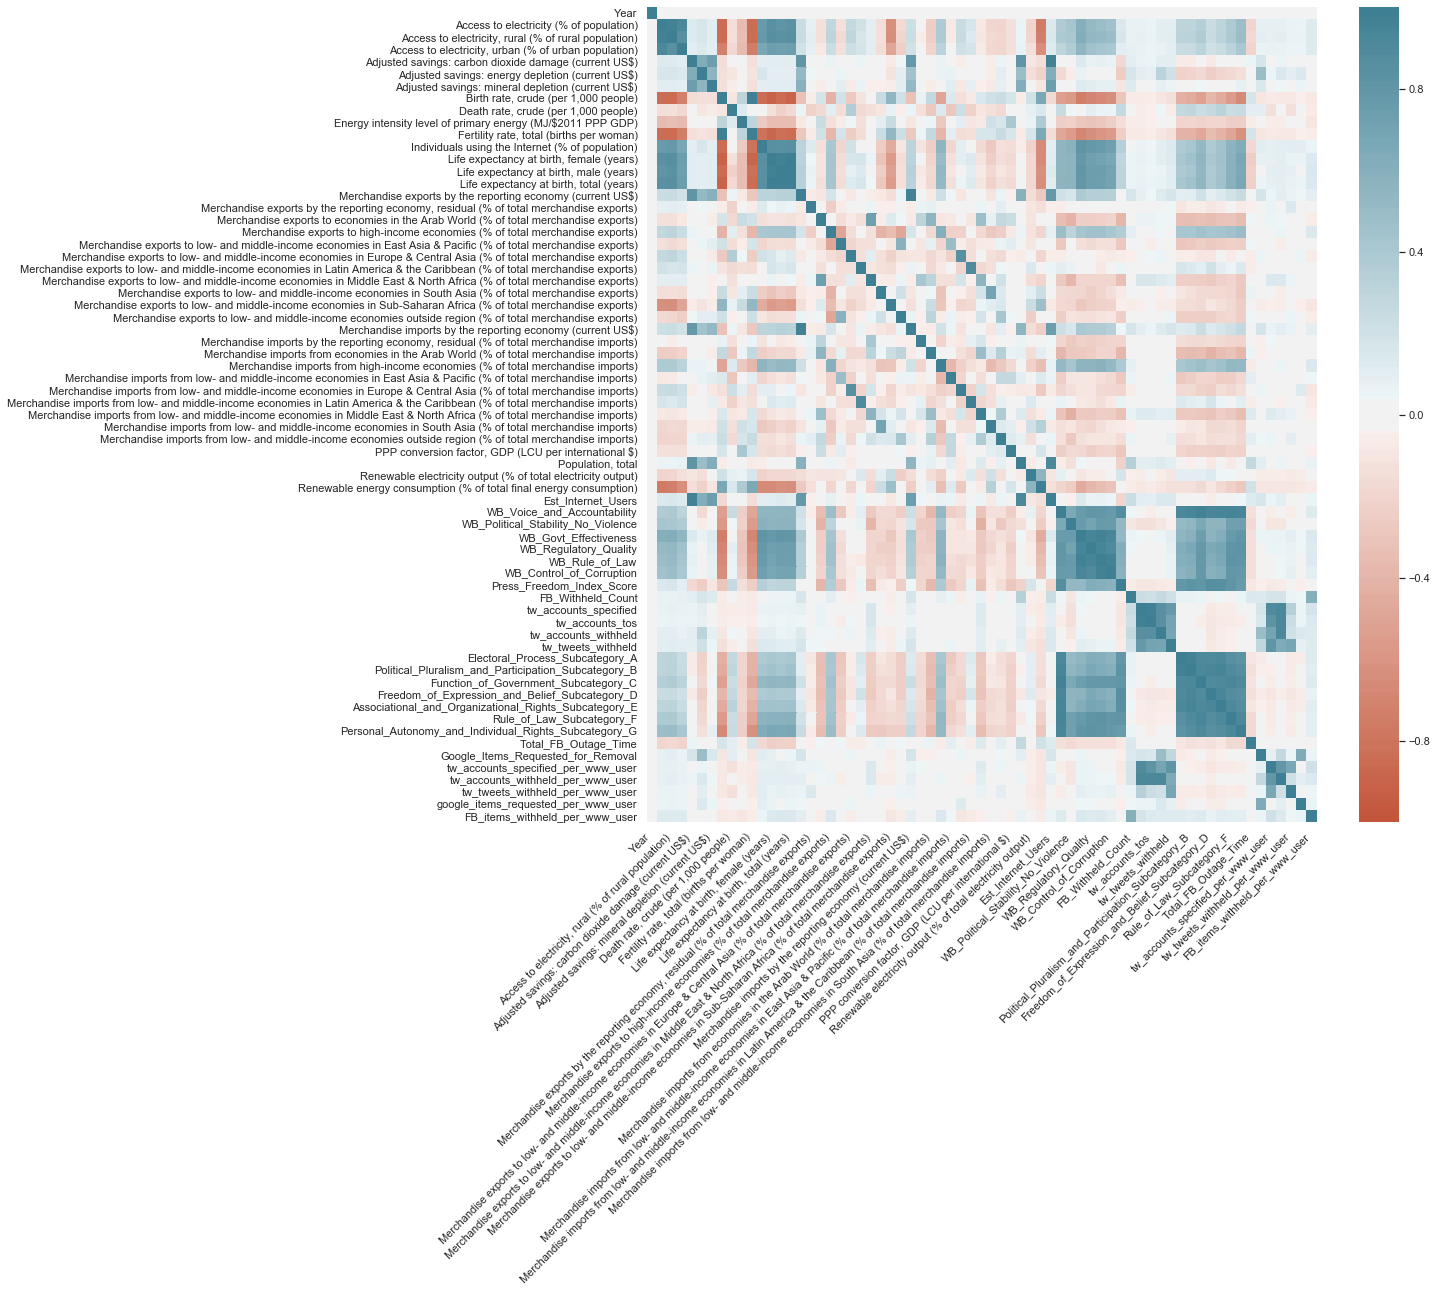

In [91]:
#Correlation plot
fig, ax = pyplot.subplots(figsize=(15, 15)) 
ax = sns.heatmap(
    df.corr(), 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=False
    
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

# Initial Analysis

### Descriptive Visualizations

In [92]:
internet_users = econ_indicators[['Country_Match','Year', 'Est_Internet_Users']]

In [93]:
twitter_granular = pd.merge(twitter_granular, internet_users, how = "left",on=['Country_Match','Year'])

In [94]:
twitter_granular['tw_removal_requests_per_www_user'] = twitter_granular['tw_removal_requests']/twitter_granular['Est_Internet_Users']
twitter_granular['tw_accounts_specified_per_www_user'] = twitter_granular['tw_accounts_specified']/twitter_granular['Est_Internet_Users']
twitter_granular['tw_accounts_withheld_per_www_user'] = twitter_granular['tw_accounts_withheld']/twitter_granular['Est_Internet_Users']
twitter_granular['tw_tweets_withheld_per_www_user'] = twitter_granular['tw_tweets_withheld']/twitter_granular['Est_Internet_Users']
twitter_granular['tw_pct_specified_accounts_tos_violations'] = twitter_granular['tw_accounts_tos']/twitter_granular['tw_accounts_specified']
twitter_granular['tw_pct_specified_accounts_withheld'] = twitter_granular['tw_accounts_withheld']/twitter_granular['tw_accounts_specified']
twitter_granular['tw_pct_requests_successful'] = twitter_granular['tw_successful_requests']/twitter_granular['tw_removal_requests']
twitter_granular['tw_pct_specified_accounts_tos_violations_or_withheld'] = (twitter_granular['tw_accounts_tos'] + twitter_granular['tw_accounts_withheld'])/twitter_granular['tw_accounts_specified']
twitter_granular['tw_pct_specified_accounts_left_intact'] = (twitter_granular['tw_accounts_specified'] - (twitter_granular['tw_accounts_tos'] + twitter_granular['tw_accounts_withheld']))/twitter_granular['tw_accounts_specified']
twitter_granular['Half_Year'] = twitter_granular['Year'].astype(str) + " " + twitter_granular['Timeframe']

In [95]:
google_granular = pd.merge(google_granular, internet_users, how = "left",on=['Country_Match','Year'])

In [96]:
#Google items requested for removal per internet user
#Google doesn't report on the number of items removed or delisted, just the number of requests complied with

google_granular['google_items_requested_per_www_user'] = google_granular['Google_Items_Requested_for_Removal']/google_granular['Est_Internet_Users']
google_granular['google_removal_requests_per_www_user'] = google_granular['google_removal_requests']/google_granular['Est_Internet_Users']
google_granular['Half_Year'] = google_granular['Year'].astype(str) + " " + google_granular['Timeframe']

In [97]:
fb_granular = pd.merge(fb_granular, internet_users, how = "left",on=['Country_Match','Year'])

In [98]:
#Facebook doesn't report out on their compliance rate
fb_granular['Half_Year'] = fb_granular['Year'].astype(str) + " " + fb_granular['Timeframe']
fb_granular['FB_items_withheld_per_www_user'] = fb_granular['FB_Withheld_Count']/fb_granular['Est_Internet_Users']
fb_granular['FB_items_withheld_per_www_user'] = fb_granular['FB_items_withheld_per_www_user'].astype(float)

In [99]:
tw_goog_fb = pd.merge(twitter_granular,google_granular, how="outer", on=['Country_Match','Year','Timeframe','Half_Year','Est_Internet_Users'])
tw_goog_fb = pd.merge(tw_goog_fb,fb_granular, how="outer", on=['Country_Match','Year','Timeframe','Half_Year','Est_Internet_Users'])


In [100]:
tw_goog_fb = tw_goog_fb.sort_values(by=['Half_Year'])

In [101]:
tw_goog_fb = tw_goog_fb[tw_goog_fb['Country_Match']!='TOTALS']

In [102]:
#google_reasons.Reason.unique()

In [103]:
#fig, ax = plt.subplots()

#reasons = google_reasons.Reason.unique()

#for reason in reasons:
#google_reasons[google_reasons['Reason']=='Other'].groupby(['Year', 'Timeframe']).Google_Total_Requests.sum().T.plot(x='Year',y='Google_Total_Requests',kind='bar',stacked=True, label='Other', color='springgreen')
#google_reasons[google_reasons['Reason']=='Copyright'].groupby(['Year', 'Timeframe']).Google_Total_Requests.sum().T.plot(x='Year',y='Google_Total_Requests',kind='bar',stacked=True, label='Copyright', color='blue')
#google_reasons[google_reasons['Reason']=='Defamation'].groupby(['Year', 'Timeframe']).Google_Total_Requests.sum().T.plot(x='Year',y='Google_Total_Requests',kind='bar',stacked=True, label='Defamation', color = 'orange')
#google_reasons[google_reasons['Reason']=='Privacy and Security'].groupby(['Year', 'Timeframe']).Google_Total_Requests.sum().T.plot(x='Year',y='Google_Total_Requests',kind='bar',stacked=True, label='Privacy and Security', color = 'yellow')
#google_reasons[google_reasons['Reason']=='Hate Speech'].groupby(['Year', 'Timeframe']).Google_Total_Requests.sum().T.plot(x='Year',y='Google_Total_Requests',kind='bar',stacked=True, label='Hate Speech', color = 'red')
#google_reasons[google_reasons['Reason']=='Adult Content'].groupby(['Year', 'Timeframe']).Google_Total_Requests.sum().T.plot(x='Year',y='Google_Total_Requests',kind='bar',stacked=True, label='Adult Content', color = 'purple')
#ax.legend()

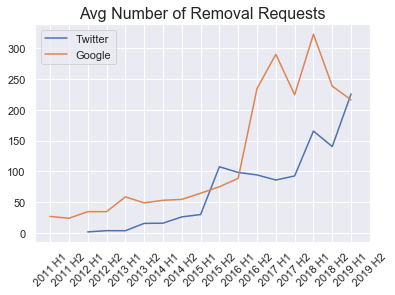

In [104]:
#Facebook doesn't report the number of requests, just the number of items withheld
tw1 = tw_goog_fb.groupby(['Half_Year']).tw_removal_requests.agg('mean').reset_index()
goog1 = tw_goog_fb.groupby(['Half_Year']).google_removal_requests.agg('mean').reset_index()
#fb1 = tw_goog_fb.groupby(['Half_Year']).FB_Withheld_Count.agg('mean').reset_index()


fig, ax = plt.subplots()
plt.plot(tw1.index, tw1['tw_removal_requests'], label="Twitter") 
#plt.xlim(1,22)
#sns.regplot(x =tw1.index, y='tw_removal_requests', data = tw1, scatter = False, ci = None, fit_reg = True, color = 'm')

plt.plot(goog1.index, goog1['google_removal_requests'], label="Google") 

#plt.plot(fb1.index, fb1['FB_Withheld_Count'], label="Facebook (Withheld Content)") 

#plt.grid(b=True, which='major', color='lightgrey', linestyle='-')

#plt.xlabel('Time Period', fontsize = 14) 
plt.ylabel('') 
#plt.ylim(0,180)
plt.title('Avg Number of Removal Requests', fontsize = 16) 
#ax.set_xticklabels([list('0') + list(google_granular['Half_Year'].unique())])
ticks = list(tw_goog_fb['Half_Year'].unique())
plt.xticks(goog1.index, ticks, rotation=45) 
ax.legend()

plt.savefig('Avg_Num_of_Removal_Requests.png', bbox_inches='tight')
                   
plt.show()

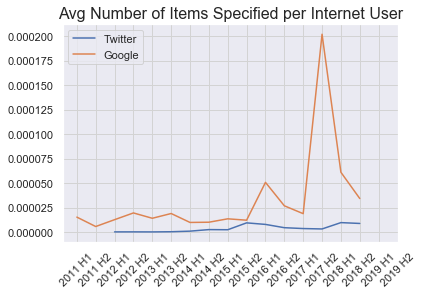

In [105]:
tw2 = tw_goog_fb.groupby(['Half_Year']).tw_accounts_specified_per_www_user.agg('mean').reset_index()
goog2 = tw_goog_fb.groupby(['Half_Year']).google_items_requested_per_www_user.agg('mean').reset_index()

fig, ax = plt.subplots()

plt.plot(tw2.index, tw2['tw_accounts_specified_per_www_user'], label="Twitter") 

plt.plot(goog2.index, goog2['google_items_requested_per_www_user'], label="Google") 

#sns.regplot(x =tw2.index, y='tw_accounts_specified_per_www_user', data = tw2, scatter = False, ci = None, fit_reg = True, color = 'm')

plt.ylabel('') 
#plt.ylim(0,.000011)
plt.title('Avg Number of Items Specified per Internet User', fontsize = 16) 
#plt.savefig('pca_2018_silhouette_scores.png', bbox_inches='tight')

plt.grid(b=True, which='major', color='lightgrey', linestyle='-')
ticks = list(tw_goog_fb['Half_Year'].unique())
plt.xticks(goog2.index, ticks, rotation=45) 
ax.legend()

plt.savefig('Avg_items_specified_per_www_user.png', bbox_inches='tight')
                   
plt.show()

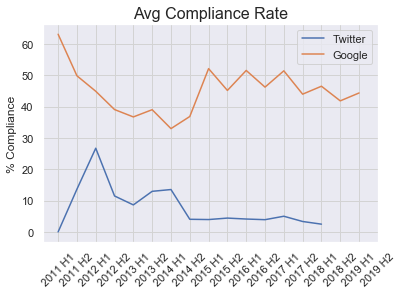

In [106]:
#twitter_granular['tw_pct_specified_accounts_left_intact']

#tw3 = tw_goog_fb.groupby(['Half_Year']).notna(tw_pct_requests_successful.agg)('mean').reset_index()
tw_graph = tw_goog_fb[tw_goog_fb['tw_pct_specified_accounts_tos_violations_or_withheld'].isna()==False]
tw3_2 =tw_goog_fb.loc[tw_goog_fb['tw_pct_requests_successful'].notna()==True, :].reset_index().set_index(['Country_Match','Half_Year']).groupby('Half_Year')['tw_pct_requests_successful'].agg('mean').reset_index()   #tw_graph.groupby(['Half_Year']).tw_pct_specified_accounts_tos_violations_or_withheld.agg('sum')
goog3 = tw_goog_fb.groupby(['Half_Year']).google_compliance_rate.agg('mean').reset_index()

fig, ax = plt.subplots()

#plt.plot(tw3.index, tw3['tw_pct_requests_successful']*100, label="Twitter") 

plt.plot(tw3_2.index, tw3_2['tw_pct_requests_successful']*100, label="Twitter") 

plt.plot(goog3.index, goog3['google_compliance_rate']*100, label="Google") 

#sns.regplot(x =tw2.index, y='tw_accounts_specified_per_www_user', data = tw2, scatter = False, ci = None, fit_reg = True, color = 'm')

plt.ylabel('% Compliance', fontsize=12) 
#plt.ylim(0,.000011)
plt.title('Avg Compliance Rate', fontsize = 16) 
#plt.savefig('pca_2018_silhouette_scores.png', bbox_inches='tight')

plt.grid(b=True, which='major', color='lightgrey', linestyle='-')
ticks = list(tw_goog_fb['Half_Year'].unique())
plt.xticks(goog3.index, ticks, rotation=45) 
ax.legend()

plt.savefig('Avg_Removal_Request_Compliance_Rate.png', bbox_inches='tight')
                   
                   
plt.show()

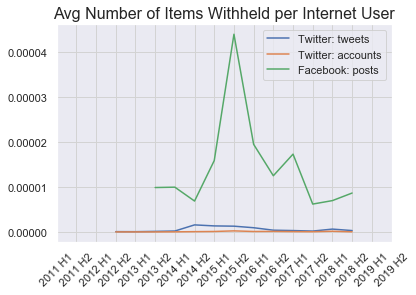

In [107]:
fb4 = tw_goog_fb.groupby(['Half_Year']).FB_items_withheld_per_www_user.agg('mean').reset_index()
tw4 = tw_goog_fb.groupby(['Half_Year']).tw_tweets_withheld_per_www_user.agg('mean').reset_index()
tw4_2 = tw_goog_fb.groupby(['Half_Year']).tw_accounts_withheld_per_www_user.agg('mean').reset_index()

fig, ax = plt.subplots()

plt.plot(tw4.index, tw4['tw_tweets_withheld_per_www_user'], label="Twitter: tweets") 

plt.plot(tw4_2.index, tw4_2['tw_accounts_withheld_per_www_user'], label="Twitter: accounts") 

plt.plot(fb4.index, fb4['FB_items_withheld_per_www_user'], label="Facebook: posts") 

#sns.regplot(x =tw2.index, y='tw_accounts_specified_per_www_user', data = tw2, scatter = False, ci = None, fit_reg = True, color = 'm')

plt.ylabel('', fontsize=12) 
#plt.ylim(0,.000011)
plt.title('Avg Number of Items Withheld per Internet User', fontsize = 16) 
#plt.savefig('pca_2018_silhouette_scores.png', bbox_inches='tight')

plt.grid(b=True, which='major', color='lightgrey', linestyle='-')
ticks = list(tw_goog_fb['Half_Year'].unique())
plt.xticks(fb4.index, ticks, rotation=45) 
ax.legend()

plt.savefig('Avg_Withheld_per_www_user.png', bbox_inches='tight')
                   
                   
plt.show()

In [108]:
tw_goog_fb.groupby(['Country_Match']).tw_removal_requests.sum().sort_values(ascending=False).head(10)

Country_Match
Turkey           36256.0
Russia           15380.0
Japan             6521.0
France            4159.0
South Korea       2492.0
India             1910.0
Indonesia         1035.0
Germany            971.0
United States      968.0
Pakistan           865.0
Name: tw_removal_requests, dtype: float64

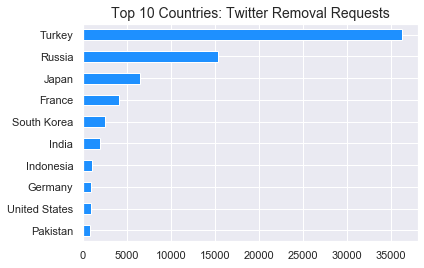

In [109]:
fig, ax = plt.subplots()

#tw_goog_fb.groupby(['Country_Match']).tw_items_withheld.sum().sort_values(ascending=False).head(10).sort_values(ascending=True).plot(kind="barh", color="dodgerblue")
tw_goog_fb.groupby(['Country_Match']).tw_removal_requests.sum().sort_values(ascending=False).head(10).sort_values(ascending=True).plot(kind="barh", color="dodgerblue")

plt.xlabel('', fontsize = 12) 
plt.ylabel('') 
#plt.ylim(0,180)
plt.title('Top 10 Countries: Twitter Removal Requests', fontsize = 14) 
#ax.set_xticklabels([list('0') + list(google_granular['Half_Year'].unique())])
ticks = list(tw_goog_fb['Half_Year'].unique())
#plt.xticks(goog1.index, ticks, rotation=45) 
#ax.legend()

plt.savefig('Top10_Twitter_Removal_Requests.png', bbox_inches='tight')
                   
plt.show()

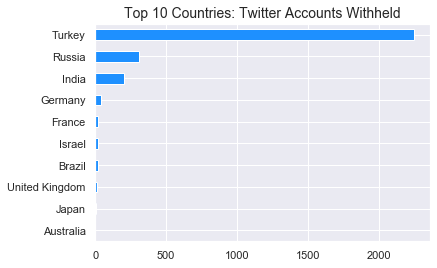

In [110]:
fig, ax = plt.subplots()

#tw_goog_fb.groupby(['Country_Match']).tw_tweets_withheld.sum().sort_values(ascending=False).head(10).sort_values(ascending=True).plot(kind="barh",color="dodgerblue")
tw_goog_fb.groupby(['Country_Match']).tw_accounts_withheld.sum().sort_values(ascending=False).head(10).sort_values(ascending=True).plot(kind="barh", color="dodgerblue")

plt.xlabel('', fontsize = 12) 
plt.ylabel('') 
#plt.ylim(0,180)
plt.title('Top 10 Countries: Twitter Accounts Withheld', fontsize = 14) 
#ax.set_xticklabels([list('0') + list(google_granular['Half_Year'].unique())])
ticks = list(tw_goog_fb['Half_Year'].unique())
#plt.xticks(goog1.index, ticks, rotation=45) 
#ax.legend()

plt.savefig('Top10_Twitter_Accounts_Withheld.png', bbox_inches='tight')
                   
plt.show()

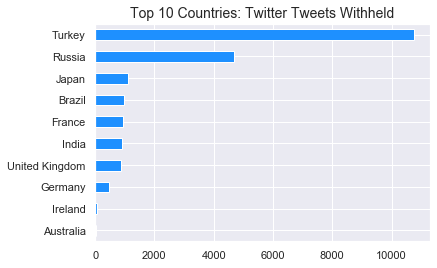

In [111]:
fig, ax = plt.subplots()

tw_goog_fb.groupby(['Country_Match']).tw_tweets_withheld.sum().sort_values(ascending=False).head(10).sort_values(ascending=True).plot(kind="barh",color="dodgerblue")
#tw_goog_fb.groupby(['Country_Match']).tw_accounts_withheld.sum().sort_values(ascending=False).head(10).sort_values(ascending=True).plot(kind="barh", color="dodgerblue")

plt.xlabel('', fontsize = 12) 
plt.ylabel('') 
#plt.ylim(0,180)
plt.title('Top 10 Countries: Twitter Tweets Withheld', fontsize = 14) 
#ax.set_xticklabels([list('0') + list(google_granular['Half_Year'].unique())])
ticks = list(tw_goog_fb['Half_Year'].unique())
#plt.xticks(goog1.index, ticks, rotation=45) 
#ax.legend()

plt.savefig('Top10_Twitter_Tweets_Withheld.png', bbox_inches='tight')
                   
plt.show()

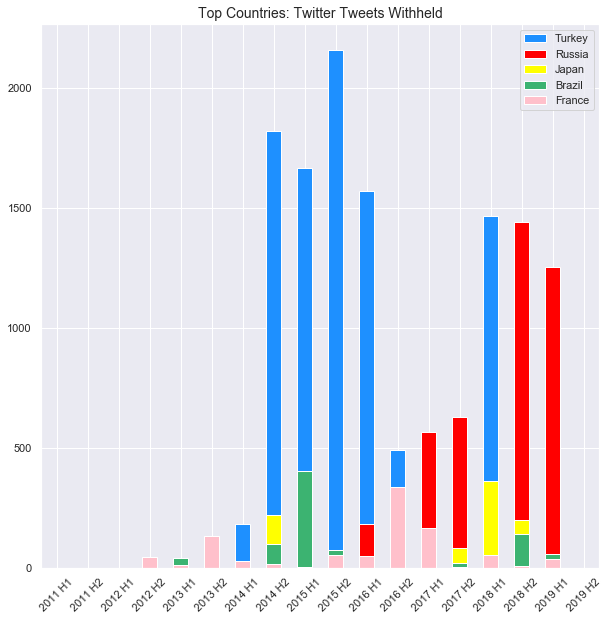

In [112]:
sns.set()
fig, ax = plt.subplots(figsize = (10,10))

#top10 = tw_goog_fb.groupby(['Country_Match']).tw_tweets_withheld.sum().sort_values(ascending=False).head(10).reset_index()

#for country in top10['Country_Match']:
    #tw_goog_fb[tw_goog_fb['Country_Match']==country][['Half_Year','tw_tweets_withheld']].T.plot(x=index, y='tw_tweets_withheld', label=country, cmap='rainbow')
#tw_goog_fb.groupby(['Country_Match']).tw_tweets_withheld.sum().sort_values(ascending=False).head(10).sort_values(ascending=True).plot(color="dodgerblue")
#tw_goog_fb.groupby(['Country_Match']).tw_accounts_withheld.sum().sort_values(ascending=False).head(10).sort_values(ascending=True).plot(kind="barh", color="dodgerblue")

tw_goog_fb[tw_goog_fb['Country_Match']=='Turkey'][['Half_Year','tw_tweets_withheld']].plot(x='Half_Year', y='tw_tweets_withheld', label='Turkey', ax=ax, kind='bar', color='dodgerblue')
tw_goog_fb[tw_goog_fb['Country_Match']=='Russia'][['Half_Year','tw_tweets_withheld']].plot(x='Half_Year', y='tw_tweets_withheld', label='Russia', ax=ax, kind='bar', color='red')
tw_goog_fb[tw_goog_fb['Country_Match']=='Japan'][['Half_Year','tw_tweets_withheld']].plot(x='Half_Year', y='tw_tweets_withheld', label='Japan', ax=ax, kind='bar', color='yellow')
tw_goog_fb[tw_goog_fb['Country_Match']=='Brazil'][['Half_Year','tw_tweets_withheld']].plot(x='Half_Year', y='tw_tweets_withheld', label='Brazil', ax=ax, kind='bar',color='mediumseagreen')
tw_goog_fb[tw_goog_fb['Country_Match']=='France'][['Half_Year','tw_tweets_withheld']].plot(x='Half_Year', y='tw_tweets_withheld', label='France', ax=ax, kind='bar', color='pink')

plt.xlabel('', fontsize = 12) 
plt.ylabel('') 
#plt.ylim(0,180)
plt.title('Top Countries: Twitter Tweets Withheld', fontsize = 14) 
#ax.set_xticklabels([list('0') + list(google_granular['Half_Year'].unique())])
ticks = list(tw_goog_fb['Half_Year'].unique())
plt.xticks(goog1.index, ticks, rotation=45) 
ax.legend()

plt.savefig('Top_Twitter_Tweets_Withheld.png', bbox_inches='tight')
                   
plt.show()

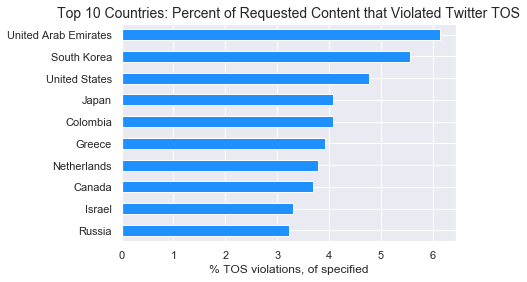

In [113]:
fig, ax = plt.subplots()

tw_goog_fb.groupby(['Country_Match']).tw_pct_specified_accounts_tos_violations.sum().sort_values(ascending=False).head(10).sort_values(ascending=True).plot(kind="barh", color="dodgerblue")

plt.xlabel('% TOS violations, of specified', fontsize = 12) 
plt.ylabel('') 
#plt.ylim(0,180)
plt.title('Top 10 Countries: Percent of Requested Content that Violated Twitter TOS', fontsize = 14) 
#ax.set_xticklabels([list('0') + list(google_granular['Half_Year'].unique())])
ticks = list(tw_goog_fb['Half_Year'].unique())
#plt.xticks(goog1.index, ticks, rotation=45) 
#ax.legend()

plt.savefig('Percent_Requested_Content_Violated_Twitter_TOS.png', bbox_inches='tight')
                   
plt.show()

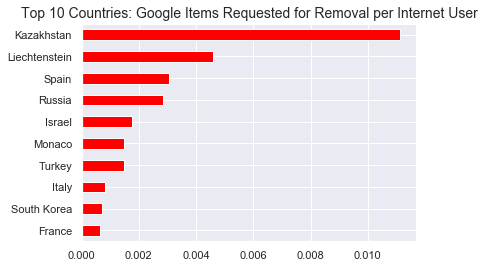

In [114]:
fig, ax = plt.subplots()

#tw_goog_fb.groupby(['Country_Match']).Google_Items_Requested_for_Removal.sum().sort_values(ascending=False).head(10).sort_values(ascending=True).plot(kind="barh", color="red")
tw_goog_fb.groupby(['Country_Match']).google_items_requested_per_www_user.sum().sort_values(ascending=False).head(10).sort_values(ascending=True).plot(kind="barh", color="red")

plt.xlabel('', fontsize = 12) 
plt.ylabel('') 
#plt.title('Top 10 Countries: Google Items Requested for Removal', fontsize = 14) 
plt.title('Top 10 Countries: Google Items Requested for Removal per Internet User', fontsize = 14) 
#ticks = list(tw_goog_fb['Half_Year'].unique())
#plt.xticks(goog1.index, ticks, rotation=45) 
#ax.legend()

#plt.savefig('Top10_Google_Items_Req.png', bbox_inches='tight')
plt.savefig('Top10_Google_Items_Req_per_www_user.png', bbox_inches='tight')
                   
plt.show()

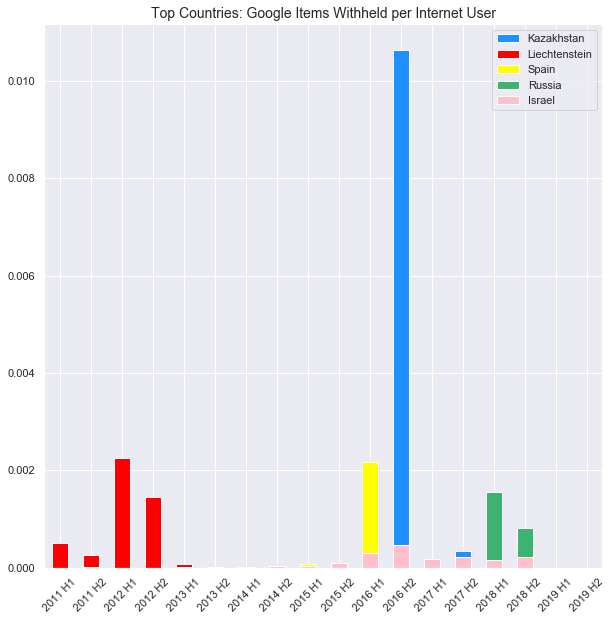

In [115]:
fig, ax = plt.subplots(figsize = (10,10))

tw_goog_fb[tw_goog_fb['Country_Match']=='Kazakhstan'][['Half_Year','google_items_requested_per_www_user']].plot(x='Half_Year', y='google_items_requested_per_www_user', label='Kazakhstan', ax=ax, kind='bar', color='dodgerblue')
tw_goog_fb[tw_goog_fb['Country_Match']=='Liechtenstein'][['Half_Year','google_items_requested_per_www_user']].plot(x='Half_Year', y='google_items_requested_per_www_user', label='Liechtenstein', ax=ax, kind='bar', color='red')
tw_goog_fb[tw_goog_fb['Country_Match']=='Spain'][['Half_Year','google_items_requested_per_www_user']].plot(x='Half_Year', y='google_items_requested_per_www_user', label='Spain', ax=ax, kind='bar', color='yellow')
tw_goog_fb[tw_goog_fb['Country_Match']=='Russia'][['Half_Year','google_items_requested_per_www_user']].plot(x='Half_Year', y='google_items_requested_per_www_user', label='Russia', ax=ax, kind='bar',color='mediumseagreen')
tw_goog_fb[tw_goog_fb['Country_Match']=='Israel'][['Half_Year','google_items_requested_per_www_user']].plot(x='Half_Year', y='google_items_requested_per_www_user', label='Israel', ax=ax, kind='bar', color='pink')

plt.xlabel('', fontsize = 12) 
plt.ylabel('') 
#plt.ylim(0,180)
plt.title('Top Countries: Google Items Withheld per Internet User', fontsize = 14) 
#ax.set_xticklabels([list('0') + list(google_granular['Half_Year'].unique())])
ticks = list(tw_goog_fb['Half_Year'].unique())
plt.xticks(goog1.index, ticks, rotation=45) 
ax.legend()

plt.savefig('Top_Google_Items_Withheld_per_www_user.png', bbox_inches='tight')
                   
plt.show()

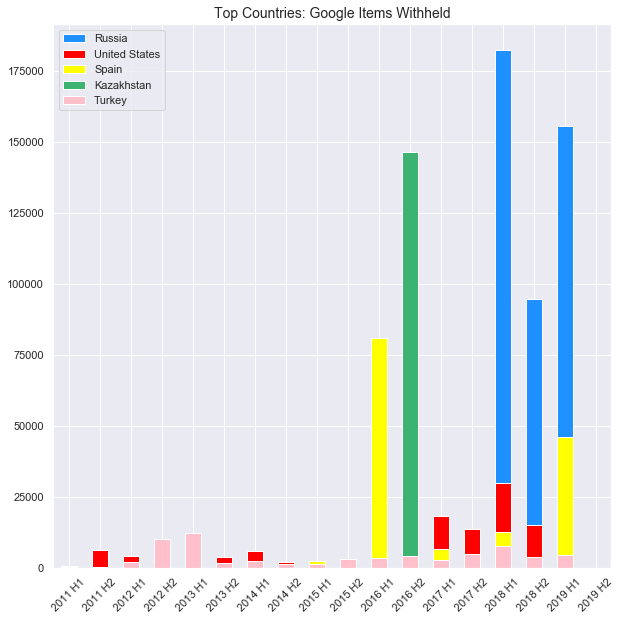

In [116]:
fig, ax = plt.subplots(figsize = (10,10))

tw_goog_fb[tw_goog_fb['Country_Match']=='Russia'][['Half_Year','Google_Items_Requested_for_Removal']].plot(x='Half_Year', y='Google_Items_Requested_for_Removal', label='Russia', ax=ax, kind='bar', color='dodgerblue')
tw_goog_fb[tw_goog_fb['Country_Match']=='United States'][['Half_Year','Google_Items_Requested_for_Removal']].plot(x='Half_Year', y='Google_Items_Requested_for_Removal', label='United States', ax=ax, kind='bar', color='red')
tw_goog_fb[tw_goog_fb['Country_Match']=='Spain'][['Half_Year','Google_Items_Requested_for_Removal']].plot(x='Half_Year', y='Google_Items_Requested_for_Removal', label='Spain', ax=ax, kind='bar', color='yellow')
tw_goog_fb[tw_goog_fb['Country_Match']=='Kazakhstan'][['Half_Year','Google_Items_Requested_for_Removal']].plot(x='Half_Year', y='Google_Items_Requested_for_Removal', label='Kazakhstan', ax=ax, kind='bar',color='mediumseagreen')
tw_goog_fb[tw_goog_fb['Country_Match']=='Turkey'][['Half_Year','Google_Items_Requested_for_Removal']].plot(x='Half_Year', y='Google_Items_Requested_for_Removal', label='Turkey', ax=ax, kind='bar', color='pink')

plt.xlabel('', fontsize = 12) 
plt.ylabel('') 
#plt.ylim(0,180)
plt.title('Top Countries: Google Items Withheld', fontsize = 14) 
#ax.set_xticklabels([list('0') + list(google_granular['Half_Year'].unique())])
ticks = list(tw_goog_fb['Half_Year'].unique())
plt.xticks(goog1.index, ticks, rotation=45) 
ax.legend()

plt.savefig('Top_Google_Items_Withheld.png', bbox_inches='tight')
                   
plt.show()

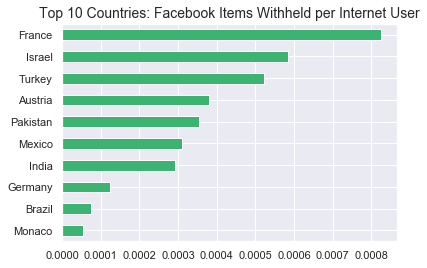

In [117]:
fig, ax = plt.subplots()

#tw_goog_fb.groupby(['Country_Match']).FB_Withheld_Count.sum().sort_values(ascending=False).head(10).sort_values(ascending=True).plot(kind="barh", color="mediumseagreen")
tw_goog_fb.groupby(['Country_Match']).FB_items_withheld_per_www_user.sum().sort_values(ascending=False).head(10).sort_values(ascending=True).plot(kind="barh", color="mediumseagreen")

plt.xlabel('', fontsize = 12) 
plt.ylabel('') 
#plt.title('Top 10 Countries: Facebook Items Withheld', fontsize = 14) 
plt.title('Top 10 Countries: Facebook Items Withheld per Internet User', fontsize = 14) 
#ticks = list(tw_goog_fb['Half_Year'].unique())
#plt.xticks(goog1.index, ticks, rotation=45) 
#ax.legend()

#plt.savefig('Top10_FB_Withheld.png', bbox_inches='tight')
plt.savefig('Top10_FB_Withheld_per_www_user.png', bbox_inches='tight')
                   
plt.show()

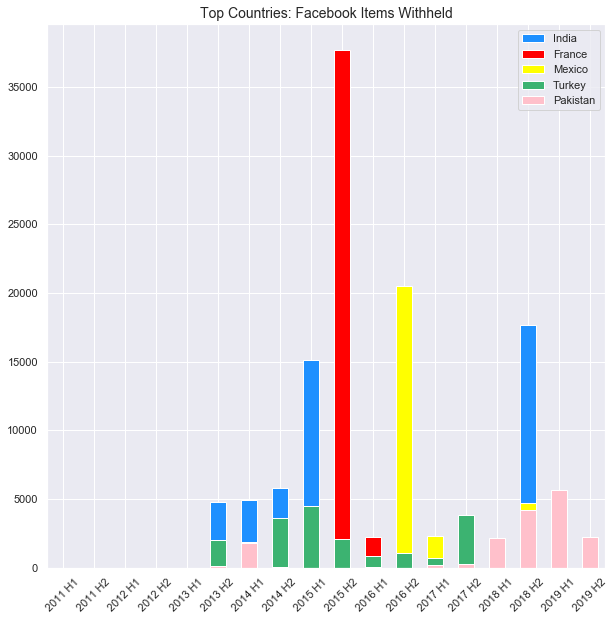

In [141]:
fig, ax = plt.subplots(figsize = (10,10))

tw_goog_fb[tw_goog_fb['Country_Match']=='India'][['Half_Year','FB_Withheld_Count']].plot(x='Half_Year', y='FB_Withheld_Count', label='India', ax=ax, kind='bar', color='dodgerblue')
tw_goog_fb[tw_goog_fb['Country_Match']=='France'][['Half_Year','FB_Withheld_Count']].plot(x='Half_Year', y='FB_Withheld_Count', label='France', ax=ax, kind='bar', color='red')
tw_goog_fb[tw_goog_fb['Country_Match']=='Mexico'][['Half_Year','FB_Withheld_Count']].plot(x='Half_Year', y='FB_Withheld_Count', label='Mexico', ax=ax, kind='bar', color='yellow')
tw_goog_fb[tw_goog_fb['Country_Match']=='Turkey'][['Half_Year','FB_Withheld_Count']].plot(x='Half_Year', y='FB_Withheld_Count', label='Turkey', ax=ax, kind='bar',color='mediumseagreen')
tw_goog_fb[tw_goog_fb['Country_Match']=='Pakistan'][['Half_Year','FB_Withheld_Count']].plot(x='Half_Year', y='FB_Withheld_Count', label='Pakistan', ax=ax, kind='bar', color='pink')

plt.xlabel('', fontsize = 12) 
plt.ylabel('') 
#plt.ylim(0,180)
plt.title('Top Countries: Facebook Items Withheld', fontsize = 14) 
#ax.set_xticklabels([list('0') + list(google_granular['Half_Year'].unique())])
ticks = list(tw_goog_fb['Half_Year'].unique())
plt.xticks(goog1.index, ticks, rotation=45) 
ax.legend()

plt.savefig('Top_FB_Items_Withheld.png', bbox_inches='tight')
                   
plt.show()

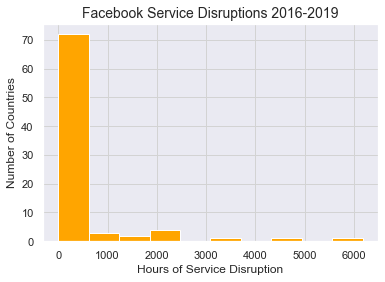

In [119]:
fb_out1 = tw_goog_fb.groupby(['Half_Year', 'Country_Match']).Total_Outage_Time.sum().reset_index()
fb_out2 = fb_out1.loc[fb_out1['Total_Outage_Time']>pd.Timedelta(seconds=0),:].reset_index()

fb_out2['Total_Outage_Time'] = fb_out2['Total_Outage_Time'].astype('timedelta64[h]')

fb_out2['Total_Outage_Time'].plot.hist(color='orange')

plt.xlabel('Hours of Service Disruption', fontsize = 12) 
plt.ylabel('Number of Countries', fontsize = 12) 
plt.title('Facebook Service Disruptions 2016-2019', fontsize = 14) 

plt.grid(b=True, which='major', color='lightgrey', linestyle='-')

plt.savefig('FB_Service_Disruptions_Hist.png', bbox_inches='tight')
                   
                   
plt.show()


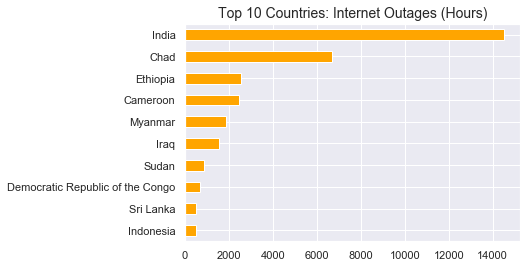

In [120]:
fig, ax = plt.subplots()


tw_goog_fb.groupby(['Country_Match']).Total_Outage_Time.sum().astype('timedelta64[h]').sort_values(ascending=False).head(10).sort_values(ascending=True).plot(kind="barh", color="orange")

plt.xlabel('', fontsize = 12) 
plt.ylabel('') 
#plt.title('Top 10 Countries: Facebook Items Withheld', fontsize = 14) 
plt.title('Top 10 Countries: Internet Outages (Hours)', fontsize = 14) 
#ticks = list(tw_goog_fb['Half_Year'].unique())
#plt.xticks(goog1.index, ticks, rotation=45) 
#ax.legend()

#plt.savefig('Top10_FB_Withheld.png', bbox_inches='tight')
plt.savefig('Top10_Internet Outages.png', bbox_inches='tight')
                   
plt.show()

In [121]:
tw_goog_fb.groupby(['Country_Match']).Total_Outage_Time.sum().astype('timedelta64[h]')[90:120]

Country_Match
Greenland                                0.0
Grenada                                  0.0
Guadeloupe                               0.0
Guam                                     0.0
Guatemala                                0.0
Guernsey                                 0.0
Guinea                                   0.0
Guinea-Bissau                            0.0
Guyana                                   0.0
Haiti                                    0.0
Heard Island and McDonald Islands        0.0
Honduras                                 0.0
Hong Kong                                0.0
Hungary                                  0.0
Iceland                                  0.0
India                                14508.0
Indonesia                              495.0
Interpol                                 0.0
Iran                                   349.0
Iraq                                  1536.0
Ireland                                  0.0
Isle Of Man                              

### Regressions

#### Regressing index scores on removal request data

In [122]:
reg_x_vars = df.reset_index().set_index(['Country_Match'])
reg_y_targets = df[['Electoral_Process_Subcategory_A', 'Political_Pluralism_and_Participation_Subcategory_B', 'Function_of_Government_Subcategory_C', 'Freedom_of_Expression_and_Belief_Subcategory_D', 'Associational_and_Organizational_Rights_Subcategory_E', 'Rule_of_Law_Subcategory_F', 'Personal_Autonomy_and_Individual_Rights_Subcategory_G','WB_Voice_and_Accountability', 'WB_Political_Stability_No_Violence', 'WB_Govt_Effectiveness', 'WB_Regulatory_Quality', 'WB_Rule_of_Law', 'WB_Control_of_Corruption', 'Press_Freedom_Index_Score']] 

In [123]:
#Keeping just the removal request data
reg_x_vars = reg_x_vars[['Year','Est_Internet_Users','Total_FB_Outage_Time', 'tw_tweets_withheld' , 'tw_accounts_withheld', 'Google_Items_Requested_for_Removal', 'FB_Withheld_Count']]
#reg_x_vars = reg_x_vars[['Year','Total_FB_Outage_Time', 'tw_accounts_specified_per_www_user' , 'tw_accounts_withheld_per_www_user', 'google_items_requested_per_www_user', 'FB_items_withheld_per_www_user']]

#### Checking VIF for multicollinearity between the removal request variables

In [124]:
vif = pd.DataFrame()
vif["variables"] = reg_x_vars.columns
vif["VIF"] = [variance_inflation_factor(reg_x_vars.values, i) for i in range(reg_x_vars.shape[1])]
vif

,variables,VIF
0,Year,1.132811
1,Est_Internet_Users,1.199322
2,Total_FB_Outage_Time,1.063251
3,tw_tweets_withheld,1.940873
4,tw_accounts_withheld,2.352271
5,Google_Items_Requested_for_Removal,1.356917
6,FB_Withheld_Count,1.167348


#### Predicting Press Freedom Index

In [125]:
reg_press_freedom = sm.OLS(reg_y_targets['Press_Freedom_Index_Score'], reg_x_vars['Year']).fit()
#preds_press_freedom = reg_press_freedom.predict(reg_x_vars)
reg_press_freedom.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                    OLS Regression Results                                    
==============================================================================================
Dep. Variable:     Press_Freedom_Index_Score   R-squared (uncentered):                   0.820
Model:                                   OLS   Adj. R-squared (uncentered):              0.820
Method:                        Least Squares   F-statistic:                              3858.
Date:                       Sun, 17 May 2020   Prob (F-statistic):                   5.07e-317
Time:                               12:08:30   Log-Likelihood:                         -3558.0
No. Observations:                        845   AIC:                                      7118.
Df Residuals:                            844   BIC:                                      7123.
Df Model:                                  1                                                  
Covariance Type:                   nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Year          -0.0173      0.000    -62.111      0.000      -0.018      -0.017
==============================================================================
Omnibus:                       91.483   Durbin-Watson:                   1.161
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              119.428
Skew:                          -0.882   Prob(JB):                     1.17e-26
Kurtosis:                       3.527   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [126]:
reg_press_freedom2 = sm.OLS(reg_y_targets['Press_Freedom_Index_Score'], reg_x_vars[['Year','Est_Internet_Users']]).fit()
reg_press_freedom3 = sm.OLS(reg_y_targets['Press_Freedom_Index_Score'], reg_x_vars[['Year','Est_Internet_Users','tw_accounts_withheld']]).fit()
reg_press_freedom4 = sm.OLS(reg_y_targets['Press_Freedom_Index_Score'], reg_x_vars[['Year','Est_Internet_Users','tw_accounts_withheld','tw_tweets_withheld']]).fit()
reg_press_freedom5 = sm.OLS(reg_y_targets['Press_Freedom_Index_Score'], reg_x_vars[['Year','Est_Internet_Users','tw_accounts_withheld','tw_tweets_withheld','Google_Items_Requested_for_Removal']]).fit()
reg_press_freedom6 = sm.OLS(reg_y_targets['Press_Freedom_Index_Score'], reg_x_vars[['Year','Est_Internet_Users','tw_accounts_withheld','tw_tweets_withheld','Google_Items_Requested_for_Removal','FB_Withheld_Count']]).fit()

In [127]:
diff_x = reg_x_vars.diff()
diff_y = reg_y_targets.diff()

In [128]:
reg_press_freedom7 = sm.OLS(diff_y['Press_Freedom_Index_Score'], diff_x[['Year','Est_Internet_Users','tw_accounts_withheld','tw_tweets_withheld','Google_Items_Requested_for_Removal','FB_Withheld_Count','Total_FB_Outage_Time']], missing='drop').fit()

In [129]:
rsf_press_freedom = summary_col([reg_press_freedom, reg_press_freedom2,reg_press_freedom3, reg_press_freedom4,reg_press_freedom5,reg_press_freedom6,reg_press_freedom7], float_format="'%0.8f'",stars=True, model_names=['Model 1','Model 2','Model 3','Model 4','Model 5','Model 6','1st Diff'],info_dict={'N':lambda x: "{0:d}".format(int(x.nobs)),'R2':lambda x: "{:.2f}".format(x.rsquared)})
rsf_press_freedom

,Model 1,Model 2,Model 3,Model 4,Model 5,Model 6,1st Diff
Est_Internet_Users,,'-0.00000005'***,'-0.00000005'***,'-0.00000005'***,'-0.00000005'***,'-0.00000005'***,'-0.00000006'***
,,('0.00000001'),('0.00000001'),('0.00000001'),('0.00000001'),('0.00000001'),('0.00000001')
FB_Withheld_Count,,,,,,'0.00002814','-0.00007973'
,,,,,,('0.00046202'),('0.00036353')
Google_Items_Requested_for_Removal,,,,,'0.00001640','0.00001643','0.00001433'
,,,,,('0.00004684'),('0.00004687'),('0.00003555')
Total_FB_Outage_Time,,,,,,,'-0.00000068'***
,,,,,,,('0.00000022')
Year,'-0.01727785'***,'-0.01679505'***,'-0.01675611'***,'-0.01675397'***,'-0.01675808'***,'-0.01675946'***,'-0.04574953'
,('0.00027818'),('0.00028533'),('0.00028636'),('0.00028747'),('0.00028786'),('0.00028892'),('0.53842104')


#### Predicting Freedom House Expression and Belief Score

In [130]:
reg_freedom_house_expression_and_belief = sm.OLS(reg_y_targets['Freedom_of_Expression_and_Belief_Subcategory_D'], reg_x_vars).fit()
preds_freedom_house_expression_and_belief = reg_freedom_house_expression_and_belief.predict(reg_x_vars)
#summary_col(results = reg, stars=True)
reg_freedom_house_expression_and_belief.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                               OLS Regression Results                                              
===================================================================================================================
Dep. Variable:     Freedom_of_Expression_and_Belief_Subcategory_D   R-squared (uncentered):                   0.844
Model:                                                        OLS   Adj. R-squared (uncentered):              0.843
Method:                                             Least Squares   F-statistic:                              648.3
Date:                                            Sun, 17 May 2020   Prob (F-statistic):                        0.00
Time:                                                    12:08:31   Log-Likelihood:                         -2456.9
No. Observations:                                             845   AIC:                                      4928.
Df Residuals:                                                 838   BIC:                                      4961.
Df Model:                                                       7                                                  
Covariance Type:                                        nonrobust                                                  
======================================================================================================
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
Year                                   0.0052   8.07e-05     64.139      0.000       0.005       0.005
Est_Internet_Users                 -2.618e-09   2.42e-09     -1.083      0.279   -7.36e-09    2.13e-09
Total_FB_Outage_Time                -2.43e-07   6.58e-08     -3.696      0.000   -3.72e-07   -1.14e-07
tw_tweets_withheld                    -0.0007      0.001     -1.124      0.261      -0.002       0.001
tw_accounts_withheld                  -0.0014      0.001     -0.933      0.351      -0.004       0.001
Google_Items_Requested_for_Removal -1.237e-05    1.3e-05     -0.950      0.342   -3.79e-05    1.32e-05
FB_Withheld_Count                      0.0003      0.000      2.549      0.011    7.58e-05       0.001
==============================================================================
Omnibus:                      141.623   Durbin-Watson:                   1.165
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               59.813
Skew:                          -0.467   Prob(JB):                     1.03e-13
Kurtosis:                       2.092   Cond. No.                     6.86e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.86e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [131]:
reg_freedom_house_expression_and_belief2 = sm.OLS(reg_y_targets['Freedom_of_Expression_and_Belief_Subcategory_D'], reg_x_vars[['Year','Est_Internet_Users']]).fit()
reg_freedom_house_expression_and_belief3 = sm.OLS(reg_y_targets['Freedom_of_Expression_and_Belief_Subcategory_D'], reg_x_vars[['Year','Est_Internet_Users','tw_accounts_withheld']]).fit()
reg_freedom_house_expression_and_belief4 = sm.OLS(reg_y_targets['Freedom_of_Expression_and_Belief_Subcategory_D'], reg_x_vars[['Year','Est_Internet_Users','tw_accounts_withheld','tw_tweets_withheld']]).fit()
reg_freedom_house_expression_and_belief5 = sm.OLS(reg_y_targets['Freedom_of_Expression_and_Belief_Subcategory_D'], reg_x_vars[['Year','Est_Internet_Users','tw_accounts_withheld','tw_tweets_withheld','Google_Items_Requested_for_Removal']]).fit()
reg_freedom_house_expression_and_belief6 = sm.OLS(reg_y_targets['Freedom_of_Expression_and_Belief_Subcategory_D'], reg_x_vars[['Year','Est_Internet_Users','tw_accounts_withheld','tw_tweets_withheld','Google_Items_Requested_for_Removal','FB_Withheld_Count']]).fit()
reg_freedom_house_expression_and_belief7 = sm.OLS(diff_y['Freedom_of_Expression_and_Belief_Subcategory_D'], diff_x[['Year','Est_Internet_Users','tw_accounts_withheld','tw_tweets_withheld','Google_Items_Requested_for_Removal','FB_Withheld_Count','Total_FB_Outage_Time']], missing='drop').fit()

In [132]:
freedom_house_expression_and_belief  = summary_col([reg_freedom_house_expression_and_belief, reg_freedom_house_expression_and_belief2,reg_freedom_house_expression_and_belief3, reg_freedom_house_expression_and_belief4,reg_freedom_house_expression_and_belief5,reg_freedom_house_expression_and_belief6,reg_freedom_house_expression_and_belief7], float_format="'%0.8f'",stars=True, model_names=['Model 1','Model 2','Model 3','Model 4','Model 5','Model 6','1st Diff'],info_dict={'N':lambda x: "{0:d}".format(int(x.nobs)),'R2':lambda x: "{:.2f}".format(x.rsquared)})
freedom_house_expression_and_belief 

,Model 1,Model 2,Model 3,Model 4,Model 5,Model 6,1st Diff
Est_Internet_Users,'-0.00000000','-0.00000000','-0.00000000','-0.00000000','-0.00000000','-0.00000000','-0.00000001'***
,('0.00000000'),('0.00000000'),('0.00000000'),('0.00000000'),('0.00000000'),('0.00000000'),('0.00000000')
FB_Withheld_Count,'0.00032935'**,,,,,'0.00027194'**,'0.00009748'
,('0.00012920'),,,,,('0.00012922'),('0.00010139')
Google_Items_Requested_for_Removal,'-0.00001237',,,,'-0.00001090','-0.00001064','0.00000344'
,('0.00001302'),,,,('0.00001314'),('0.00001311'),('0.00000991')
Total_FB_Outage_Time,'-0.00000024'***,,,,,,'-0.00000025'***
,('0.00000007'),,,,,,('0.00000006')
Year,'0.00517778'***,'0.00513130'***,'0.00514869'***,'0.00515458'***,'0.00515731'***,'0.00514395'***,'-0.06981564'
,('0.00008073'),('0.00008024'),('0.00008037'),('0.00008064'),('0.00008072'),('0.00008081'),('0.15016322')


#### Predicting World Bank Voice and Accountability

In [133]:
reg_wb_voice_and_accountability = sm.OLS(reg_y_targets['WB_Voice_and_Accountability'], reg_x_vars).fit()
preds_wb_voice_and_accountability = reg_wb_voice_and_accountability.predict(reg_x_vars)
#summary_col(results = reg, stars=True)
reg_wb_voice_and_accountability.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     OLS Regression Results                                     
================================================================================================
Dep. Variable:     WB_Voice_and_Accountability   R-squared (uncentered):                   0.040
Model:                                     OLS   Adj. R-squared (uncentered):              0.032
Method:                          Least Squares   F-statistic:                              4.930
Date:                         Sun, 17 May 2020   Prob (F-statistic):                    1.78e-05
Time:                                 12:08:31   Log-Likelihood:                         -1176.8
No. Observations:                          845   AIC:                                      2368.
Df Residuals:                              838   BIC:                                      2401.
Df Model:                                    7                                                  
Covariance Type:                     nonrobust                                                  
======================================================================================================
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
Year                               -5.717e-05   1.77e-05     -3.221      0.001    -9.2e-05   -2.23e-05
Est_Internet_Users                 -5.512e-11   5.32e-10     -0.104      0.917    -1.1e-09    9.88e-10
Total_FB_Outage_Time               -5.691e-08   1.45e-08     -3.937      0.000   -8.53e-08   -2.85e-08
tw_tweets_withheld                 -3.151e-05      0.000     -0.220      0.826      -0.000       0.000
tw_accounts_withheld                  -0.0002      0.000     -0.474      0.636      -0.001       0.000
Google_Items_Requested_for_Removal  -1.17e-06   2.86e-06     -0.409      0.683   -6.79e-06    4.45e-06
FB_Withheld_Count                   6.029e-05   2.84e-05      2.123      0.034    4.54e-06       0.000
==============================================================================
Omnibus:                      103.680   Durbin-Watson:                   1.152
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               28.331
Skew:                          -0.061   Prob(JB):                     7.05e-07
Kurtosis:                       2.111   Cond. No.                     6.86e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.86e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [134]:
reg_wb_voice_and_accountability2 = sm.OLS(reg_y_targets['WB_Voice_and_Accountability'], reg_x_vars[['Year','Est_Internet_Users']]).fit()
reg_wb_voice_and_accountability3 = sm.OLS(reg_y_targets['WB_Voice_and_Accountability'], reg_x_vars[['Year','Est_Internet_Users','tw_accounts_withheld']]).fit()
reg_wb_voice_and_accountability4 = sm.OLS(reg_y_targets['WB_Voice_and_Accountability'], reg_x_vars[['Year','Est_Internet_Users','tw_accounts_withheld','tw_tweets_withheld']]).fit()
reg_wb_voice_and_accountability5 = sm.OLS(reg_y_targets['WB_Voice_and_Accountability'], reg_x_vars[['Year','Est_Internet_Users','tw_accounts_withheld','tw_tweets_withheld','Google_Items_Requested_for_Removal']]).fit()
reg_wb_voice_and_accountability6 = sm.OLS(reg_y_targets['WB_Voice_and_Accountability'], reg_x_vars[['Year','Est_Internet_Users','tw_accounts_withheld','tw_tweets_withheld','Google_Items_Requested_for_Removal','FB_Withheld_Count']]).fit()
reg_wb_voice_and_accountability7 = sm.OLS(diff_y['WB_Voice_and_Accountability'], diff_x[['Year','Est_Internet_Users','tw_accounts_withheld','tw_tweets_withheld','Google_Items_Requested_for_Removal','FB_Withheld_Count','Total_FB_Outage_Time']], missing='drop').fit()

In [135]:
wb_voice_and_accountability  = summary_col([reg_wb_voice_and_accountability, reg_wb_voice_and_accountability2,reg_wb_voice_and_accountability3, reg_wb_voice_and_accountability4,reg_wb_voice_and_accountability5,reg_wb_voice_and_accountability6,reg_wb_voice_and_accountability7], float_format="'%0.8f'",stars=True, model_names=['Model 1','Model 2','Model 3','Model 4','Model 5','Model 6','1st Diff'],info_dict={'N':lambda x: "{0:d}".format(int(x.nobs)),'R2':lambda x: "{:.2f}".format(x.rsquared)})
wb_voice_and_accountability

,Model 1,Model 2,Model 3,Model 4,Model 5,Model 6,1st Diff
Est_Internet_Users,'-0.00000000','-0.00000000','-0.00000000','-0.00000000','-0.00000000','-0.00000000','-0.00000000'***
,('0.00000000'),('0.00000000'),('0.00000000'),('0.00000000'),('0.00000000'),('0.00000000'),('0.00000000')
FB_Withheld_Count,'0.00006029'**,,,,,'0.00004685'*,'0.00001754'
,('0.00002840'),,,,,('0.00002844'),('0.00002223')
Google_Items_Requested_for_Removal,'-0.00000117',,,,'-0.00000081','-0.00000077','0.00000039'
,('0.00000286'),,,,('0.00000289'),('0.00000289'),('0.00000217')
Total_FB_Outage_Time,'-0.00000006'***,,,,,,'-0.00000006'***
,('0.00000001'),,,,,,('0.00000001')
Year,'-0.00005717'***,'-0.00006413'***,'-0.00006306'***,'-0.00006299'***,'-0.00006279'***,'-0.00006509'***,'0.00264419'
,('0.00001775'),('0.00001757'),('0.00001765'),('0.00001772'),('0.00001775'),('0.00001778'),('0.03292957')


# PCA and Agglomerative Clustering

In [142]:
#because these percentages can't be filled with 0 for countries with no requests that year, I'm taking them out for now.  
#Removing Status because it is less precise than the scores that comprise it.

data_clust = df
#data_clust = data_clust.drop(['tw_pct_tos_violations','tw_pct_accounts_withheld','tw_pct_tos_or_withheld','tw_pct_accounts_left_intact','Status'],axis=1)
data_clust = data_clust.reset_index()

In [143]:
#data_clust = data_clust.drop(['Political_Rights_Rating','Civil_Liberties_Rating','Civil_Liberties_Raw_Score_DEFG','Political_Rights_Raw_Score_ABC','Total_Agg_Score'], axis=1)
#data_clust = data_clust.reset_index()

In [144]:
data_clust_2016 = data_clust.loc[data_clust['Year']==2016,:]
data_clust_2017 = data_clust.loc[data_clust['Year']==2017,:]
data_clust_2018 = data_clust.loc[data_clust['Year']==2018,:]


In [145]:
data_clust_2016 = data_clust_2016.set_index(['Country_Match','Year'])
data_clust_2017 = data_clust_2017.set_index(['Country_Match','Year'])
data_clust_2018 = data_clust_2018.set_index(['Country_Match','Year'])

In [146]:
data_clust_2016 = data_clust_2016.dropna(axis=1)
data_clust_2017 = data_clust_2017.dropna(axis=1)
data_clust_2018 = data_clust_2018.dropna(axis=1)

## 2016

In [147]:
pca_clust_2016 = data_clust_2016

pca_clust_2016 = pca_clust_2016.drop([#'Fixed telephone subscriptions','Mobile cellular subscriptions','Rural population','Secure Internet servers','Urban population',
                        'Est_Internet_Users','FB_Withheld_Count','Google_Items_Requested_for_Removal','tw_accounts_specified', 'tw_accounts_tos', 'tw_accounts_withheld','tw_tweets_withheld',], axis=1)


In [148]:
scaler = StandardScaler()
scaled_2016 = scaler.fit_transform(pca_clust_2016)

In [149]:
pca_clust_2016.shape

(169, 59)

In [150]:
#PCA for dimensionality reduction
#Choose number of principal compnents to use

pca_2016 = PCA(n_components = 59) 
principal_2016 = pd.DataFrame(pca_2016.fit_transform(scaled_2016))#,columns=['P1','P2','P3','P4','P5']) #, 'P6','P7','P8'])
print('Percent of variance explained by the principal components: ' + str((pca_2016.explained_variance_ratio_)))
print('Overall R-squared: ' + str(sum((pca_2016.explained_variance_ratio_)*100)))
var_2016 = np.cumsum((pca_2016.explained_variance_ratio_)*100)


Percent of variance explained by the principal components: [2.97972836e-01 1.07821475e-01 6.90723661e-02 5.15392415e-02
 4.49729369e-02 4.27778105e-02 4.00552388e-02 3.34335783e-02
 3.03170303e-02 2.58360532e-02 2.21983585e-02 1.92842164e-02
 1.89973938e-02 1.80799257e-02 1.75540336e-02 1.58117684e-02
 1.39271870e-02 1.33443034e-02 1.15092282e-02 1.01513917e-02
 9.67862828e-03 8.54636313e-03 8.40021530e-03 6.98568329e-03
 6.70337215e-03 5.90017583e-03 5.72553087e-03 4.92250377e-03
 4.49488609e-03 4.00683388e-03 3.59564918e-03 3.12204358e-03
 2.88705256e-03 2.10144332e-03 1.92857784e-03 1.82050488e-03
 1.61057335e-03 1.55527359e-03 1.46988177e-03 1.22895129e-03
 1.04346250e-03 9.55671659e-04 8.73411997e-04 7.83967430e-04
 7.64038287e-04 6.59156732e-04 5.77140890e-04 5.27489003e-04
 4.72913608e-04 4.39273284e-04 3.82602661e-04 2.81389779e-04
 2.58372532e-04 2.26946796e-04 1.96829668e-04 1.38826783e-04
 7.69787978e-05 6.07911671e-07 4.03122956e-07]
Overall R-squared: 99.99999999999994


In [151]:
print(var_2016)

[ 29.79728355  40.57943103  47.48666764  52.64059179  57.13788548
  61.41566653  65.42119041  68.76454825  71.79625127  74.3798566
  76.59969244  78.52811409  80.42785347  82.23584603  83.9912494
  85.57242624  86.96514494  88.29957527  89.45049809  90.46563726
  91.43350009  92.2881364   93.12815793  93.82672626  94.49706348
  95.08708106  95.65963415  96.15188452  96.60137313  97.00205652
  97.36162144  97.6738258   97.96253105  98.17267538  98.36553317
  98.54758366  98.70864099  98.86416835  99.01115653  99.13405166
  99.23839791  99.33396507  99.42130627  99.49970301  99.57610684
  99.64202252  99.69973661  99.75248551  99.79977687  99.84370419
  99.88196446  99.91010344  99.93594069  99.95863537  99.97831834
  99.99220102  99.9998989   99.99995969 100.        ]


In [152]:
components_2016 = pd.DataFrame(abs(pca_2016.components_), columns = pca_clust_2016.columns, index=principal_2016.columns)
components_2016


,Access to electricity (% of population),"Access to electricity, rural (% of rural population)","Access to electricity, urban (% of urban population)",Adjusted savings: carbon dioxide damage (current US$),Adjusted savings: energy depletion (current US$),Adjusted savings: mineral depletion (current US$),"Birth rate, crude (per 1,000 people)","Death rate, crude (per 1,000 people)",Energy intensity level of primary energy (MJ/$2011 PPP GDP),"Fertility rate, total (births per woman)",...,Freedom_of_Expression_and_Belief_Subcategory_D,Associational_and_Organizational_Rights_Subcategory_E,Rule_of_Law_Subcategory_F,Personal_Autonomy_and_Individual_Rights_Subcategory_G,Total_FB_Outage_Time,tw_accounts_specified_per_www_user,tw_accounts_withheld_per_www_user,tw_tweets_withheld_per_www_user,google_items_requested_per_www_user,FB_items_withheld_per_www_user
0,0.168513,0.171457,0.149269,0.024607,0.002320,0.029720,0.200342,0.015982,0.084937,0.188812,...,0.179906,0.189322,0.207671,0.218515,0.050350,0.011467,0.019704,0.029801,0.039447,0.049060
1,0.213448,0.209759,0.199594,0.166485,0.203684,0.116159,0.147041,0.151985,0.058418,0.157971,...,0.213762,0.179239,0.145951,0.108029,0.037259,0.074627,0.070953,0.108644,0.016198,0.003795
2,0.127975,0.123205,0.119318,0.393364,0.265058,0.340625,0.074617,0.017755,0.046554,0.087474,...,0.034530,0.035201,0.030483,0.029639,0.029142,0.015866,0.005457,0.027114,0.003913,0.014270
3,0.113177,0.097211,0.113650,0.031409,0.045112,0.069415,0.055795,0.056321,0.019346,0.092572,...,0.023076,0.072246,0.072735,0.013931,0.018324,0.311770,0.323316,0.262540,0.106158,0.099225
4,0.003806,0.012542,0.031424,0.138541,0.086195,0.070938,0.049663,0.403398,0.105457,0.038542,...,0.015796,0.017509,0.030523,0.005864,0.055820,0.079207,0.086582,0.102745,0.014706,0.025494
5,0.054244,0.041177,0.072476,0.071878,0.013481,0.068670,0.009083,0.046960,0.023388,0.026695,...,0.095578,0.052806,0.043724,0.018451,0.028937,0.290164,0.279797,0.214443,0.004645,0.023349
6,0.006990,0.009548,0.000866,0.118976,0.010811,0.060528,0.013424,0.098184,0.040626,0.006941,...,0.065338,0.067992,0.012213,0.000547,0.007751,0.386087,0.382800,0.350055,0.016143,0.110844
7,0.088939,0.107879,0.083068,0.066642,0.009065,0.062542,0.036621,0.016914,0.121848,0.053049,...,0.020346,0.033441,0.041425,0.006839,0.147391,0.046536,0.052694,0.041876,0.010539,0.008553
8,0.014181,0.033538,0.050559,0.010668,0.070201,0.056287,0.031561,0.142653,0.175820,0.043766,...,0.120254,0.156580,0.074006,0.054017,0.009942,0.013566,0.005465,0.010943,0.026908,0.126465
9,0.041107,0.014332,0.046789,0.047069,0.077569,0.003791,0.038694,0.102873,0.502610,0.023151,...,0.005592,0.005274,0.065114,0.086970,0.183168,0.021146,0.016351,0.038409,0.040395,0.142837


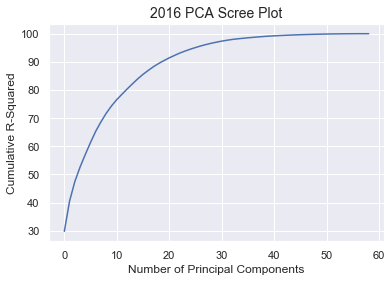

In [153]:
plt.plot(var_2016)
plt.title("2016 PCA Scree Plot", fontsize=14)
plt.xlabel("Number of Principal Components")
plt.ylabel("Cumulative R-Squared")
plt.savefig('pca_2016_scree_plot.png', bbox_inches='tight')

In [154]:
pca_2016 = PCA(n_components = 40) 
principal_2016 = pd.DataFrame(pca_2016.fit_transform(scaled_2016))

In [155]:
components_2016 = pd.DataFrame(pca_2016.components_, columns = pca_clust_2016.columns, index=principal_2016.columns)
components_2016.transpose()

,0,1,2,3,4,5,6,7,8,9,...,30,31,32,33,34,35,36,37,38,39
Access to electricity (% of population),-0.168513,0.213448,-0.127975,-0.113177,-0.003806,0.054244,0.006990,0.088939,0.014181,-0.041107,...,-0.082663,-0.074517,-0.002781,0.052426,0.047126,0.058651,-0.228007,0.079479,-0.099769,0.158077
"Access to electricity, rural (% of rural population)",-0.171457,0.209759,-0.123205,-0.097211,0.012542,0.041177,0.009548,0.107879,0.033538,-0.014332,...,0.005313,-0.024266,-0.107840,-0.036089,-0.056054,-0.081848,-0.413385,0.269047,-0.186385,0.251891
"Access to electricity, urban (% of urban population)",-0.149269,0.199594,-0.119318,-0.113650,-0.031424,0.072476,0.000866,0.083068,0.050559,-0.046789,...,-0.344614,-0.000827,0.173386,0.122792,0.341683,0.150696,0.205175,-0.136762,0.066818,-0.188220
Adjusted savings: carbon dioxide damage (current US$),-0.024607,0.166485,0.393364,-0.031409,0.138541,0.071878,-0.118976,0.066642,0.010668,-0.047069,...,-0.000462,-0.052110,0.076431,-0.070299,-0.037675,-0.126053,-0.039347,-0.121331,-0.070705,-0.125059
Adjusted savings: energy depletion (current US$),-0.002320,0.203684,0.265058,-0.045112,0.086195,0.013481,-0.010811,-0.009065,0.070201,-0.077569,...,0.015995,0.397861,0.068688,-0.125132,0.049367,0.100022,0.012581,0.027925,0.047021,0.029679
Adjusted savings: mineral depletion (current US$),-0.029720,0.116159,0.340625,-0.069415,0.070938,0.068670,-0.060528,0.062542,-0.056287,0.003791,...,-0.025471,-0.082358,-0.032331,0.062394,0.047012,-0.045951,-0.034675,0.046097,0.051250,0.049264
"Birth rate, crude (per 1,000 people)",0.200342,-0.147041,0.074617,0.055795,-0.049663,0.009083,0.013424,-0.036621,-0.031561,-0.038694,...,-0.216643,0.036009,-0.103696,-0.000904,0.001580,-0.081658,-0.072271,0.033275,-0.232661,-0.118777
"Death rate, crude (per 1,000 people)",-0.015982,-0.151985,0.017755,0.056321,0.403398,-0.046960,-0.098184,-0.016914,-0.142653,0.102873,...,-0.108527,0.071982,0.128717,-0.137947,0.055425,-0.171927,-0.099826,-0.026300,-0.094298,-0.137057
Energy intensity level of primary energy (MJ/$2011 PPP GDP),0.084937,-0.058418,0.046554,0.019346,0.105457,-0.023388,-0.040626,0.121848,0.175820,0.502610,...,0.057535,0.043653,0.031620,0.113984,-0.036436,-0.007364,-0.080081,0.043858,0.009636,-0.117831
"Fertility rate, total (births per woman)",0.188812,-0.157971,0.087474,0.092572,-0.038542,-0.026695,0.006941,-0.053049,-0.043766,-0.023151,...,-0.277031,0.064085,-0.026215,-0.126299,-0.098117,-0.120002,-0.159830,0.084068,-0.315626,-0.253726


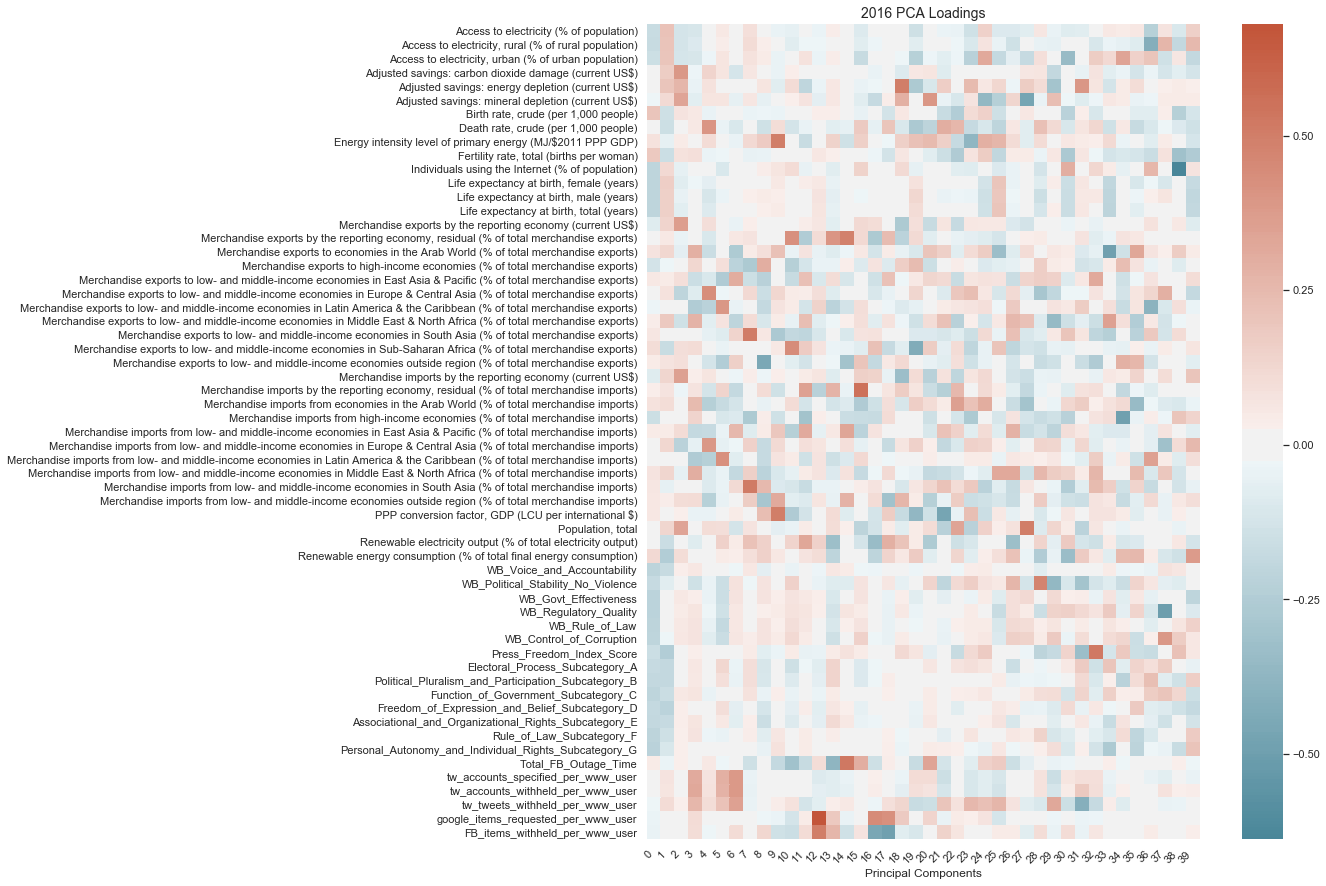

In [156]:
fig, ax = plt.subplots(figsize =(15, 15))

sns.heatmap(
    components_2016.transpose(), 
    #vmin=-1e-8, vmax=1e-8, 
    center=0,
    cmap= sns.diverging_palette(220,20, n=300),#"RdBu_r", 25),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
)
plt.xlabel('Principal Components', fontsize=12)

plt.title('2016 PCA Loadings', fontsize=14)

plt.savefig('pca_2016_loadings_heatmap.png', bbox_inches='tight')

plt.show()

In [158]:
components_2016.iloc[0,:].sort_values(ascending=False).head(10)

Birth rate, crude (per 1,000 people)                                                                                        0.200342
Fertility rate, total (births per woman)                                                                                    0.188812
Renewable energy consumption (% of total final energy consumption)                                                          0.122204
Merchandise exports to low- and middle-income economies in Sub-Saharan Africa (% of total merchandise exports)              0.099068
Merchandise imports from economies in the Arab World (% of total merchandise imports)                                       0.086619
Energy intensity level of primary energy (MJ/$2011 PPP GDP)                                                                 0.084937
Merchandise imports from low- and middle-income economies in Middle East & North Africa (% of total merchandise imports)    0.077064
Merchandise exports to economies in the Arab World (% of total mercha

In [159]:
components_2016.iloc[3,:].sort_values(ascending=False).head(10)

tw_accounts_withheld_per_www_user                                                                                           0.323316
tw_accounts_specified_per_www_user                                                                                          0.311770
Merchandise imports from low- and middle-income economies in Middle East & North Africa (% of total merchandise imports)    0.299590
Merchandise exports to economies in the Arab World (% of total merchandise exports)                                         0.290388
Merchandise exports to low- and middle-income economies in Middle East & North Africa (% of total merchandise exports)      0.274587
tw_tweets_withheld_per_www_user                                                                                             0.262540
Merchandise imports from economies in the Arab World (% of total merchandise imports)                                       0.242800
Merchandise imports from high-income economies (% of total merchandis

In [165]:
components_2016.iloc[15,:].sort_values(ascending=False).head(10)

Merchandise imports by the reporting economy, residual (% of total merchandise imports)                    0.559544
Total_FB_Outage_Time                                                                                       0.295454
Merchandise exports to low- and middle-income economies outside region (% of total merchandise exports)    0.203655
Death rate, crude (per 1,000 people)                                                                       0.185543
Merchandise imports by the reporting economy (current US$)                                                 0.156358
Energy intensity level of primary energy (MJ/$2011 PPP GDP)                                                0.155530
WB_Control_of_Corruption                                                                                   0.154136
Individuals using the Internet (% of population)                                                           0.146532
Merchandise exports by the reporting economy, residual (% of total merch

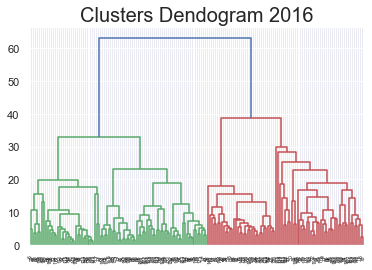

In [191]:
#dendogram; the maximum vertical distance between tree nodes should approximate the optimum number of clusters
fig, ax = plt.subplots()#figsize =(15, 15))
plt.title('Clusters Dendogram 2016', fontsize = 20) 
Dendrogram = shc.dendrogram((shc.linkage(principal_2016, method ='ward'))) 
plt.show()

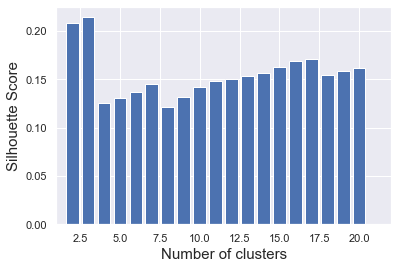

In [190]:
#Silhouette scores; higher score means more similarity within clusters and more dissimilarity to other clusters
clusters = list(range(2,21))
silhouette_scores_2016 = []

for k in clusters:
    ac = AgglomerativeClustering(n_clusters = k, linkage='ward',affinity='euclidean') 
    silhouette_scores_2016.append(silhouette_score(principal_2016, ac.fit_predict(principal_2016)))
    
fig, ax = plt.subplots()
plt.bar(clusters, silhouette_scores_2016) 
plt.xlim(1,22)
plt.xlabel('Number of clusters', fontsize = 15) 
plt.ylabel('Silhouette Score', fontsize = 15) 
plt.show()

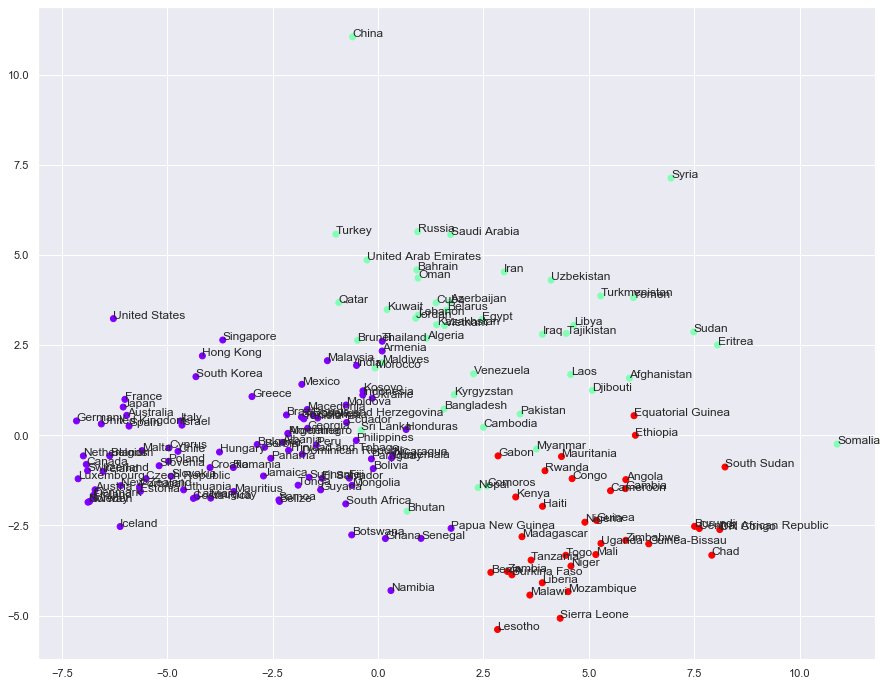

In [192]:
#choose number of clusters

agg_2016 = AgglomerativeClustering(n_clusters = 3, linkage='ward',affinity='euclidean') 
  
fig, ax = plt.subplots(figsize =(15,12))
x = principal_2016.iloc[:,0] #1st principal component; highest R-squared
y = principal_2016.iloc[:,1] #2nd principal component; 2nd highest R-squared
clust_2016 = agg_2016.fit_predict(principal_2016)
plt.scatter(x, y, c = clust_2016, cmap ='rainbow', label=clust_2016) 

countries_2016 = list(pca_clust_2016.reset_index()['Country_Match'])
    #years = list(df_c.reset_index()['Year'])

for i, country in enumerate(countries_2016):
    ax.annotate(country, (x[i], y[i]))
    
    #for i, year in enumerate(years):
        #ax.annotate(year, (x[i], y[i]))
    
plt.show() 
    

In [172]:
pca_clust_2016['cluster'] = clust_2016

In [235]:
silhouette_score(principal_2016, agg_2018.fit_predict(principal_2016))

0.21433974429172314

## 2017

In [175]:
pca_clust_2017 = data_clust_2017

pca_clust_2017 = pca_clust_2017.drop([#'Fixed telephone subscriptions','Mobile cellular subscriptions','Rural population','Secure Internet servers','Urban population',
                        'Est_Internet_Users','FB_Withheld_Count','Google_Items_Requested_for_Removal','tw_accounts_specified', 'tw_accounts_tos', 'tw_accounts_withheld','tw_tweets_withheld',], axis=1)


In [176]:
scaler = StandardScaler()
scaled_2017 = scaler.fit_transform(pca_clust_2017)

In [177]:
pca_clust_2017.shape

(169, 59)

In [178]:
#PCA for dimensionality reduction
#Choose number of principal compnents to use

pca_2017 = PCA(n_components = 59) 
principal_2017 = pd.DataFrame(pca_2017.fit_transform(scaled_2017))#,columns=['P1','P2','P3','P4','P5']) #, 'P6','P7','P8'])
print('Percent of variance explained by the principal components: ' + str((pca_2017.explained_variance_ratio_)))
print('Overall R-squared: ' + str(sum((pca_2017.explained_variance_ratio_)*100)))
var_2017 = np.cumsum((pca_2017.explained_variance_ratio_)*100)

Percent of variance explained by the principal components: [2.97289212e-01 1.08437299e-01 7.02400255e-02 5.11741326e-02
 4.51156496e-02 4.37050126e-02 4.18303934e-02 3.36875304e-02
 2.96650859e-02 2.59022545e-02 2.16939183e-02 1.97380940e-02
 1.88010826e-02 1.83830993e-02 1.75743977e-02 1.56600422e-02
 1.37732927e-02 1.27250245e-02 1.14691289e-02 1.03274043e-02
 1.01243391e-02 8.51098997e-03 8.31535692e-03 7.33076667e-03
 6.12987595e-03 6.08264081e-03 5.25895387e-03 4.99356973e-03
 4.35307057e-03 3.88331015e-03 3.55093703e-03 2.49531636e-03
 2.33329362e-03 2.18310707e-03 1.92024678e-03 1.65874161e-03
 1.56921365e-03 1.32040841e-03 1.25617093e-03 1.23604769e-03
 1.08692931e-03 9.47550128e-04 8.21820240e-04 7.33145101e-04
 6.91858271e-04 6.32292392e-04 5.76162082e-04 5.00260247e-04
 4.30671404e-04 3.57257512e-04 3.46959608e-04 3.10679931e-04
 2.39798305e-04 2.26299040e-04 1.80691790e-04 1.40360198e-04
 7.78738160e-05 5.39579466e-07 4.14955284e-07]
Overall R-squared: 100.00000000000003


In [180]:
print(var_2017)

[ 29.72892117  40.57265104  47.59665359  52.71406685  57.22563181
  61.59613307  65.77917241  69.14792545  72.11443403  74.70465948
  76.87405131  78.8478607   80.72796897  82.5662789   84.32371866
  85.88972288  87.26705216  88.5395546   89.68646749  90.71920792
  91.73164183  92.58274083  93.41427652  94.14735319  94.76034078
  95.36860486  95.89450025  96.39385722  96.82916428  97.21749529
  97.572589    97.82212063  98.05545     98.2737607   98.46578538
  98.63165954  98.78858091  98.92062175  99.04623884  99.16984361
  99.27853654  99.37329155  99.45547358  99.52878809  99.59797391
  99.66120315  99.71881936  99.76884539  99.81191253  99.84763828
  99.88233424  99.91340223  99.93738206  99.96001197  99.97808115
  99.99211716  99.99990455  99.9999585  100.        ]


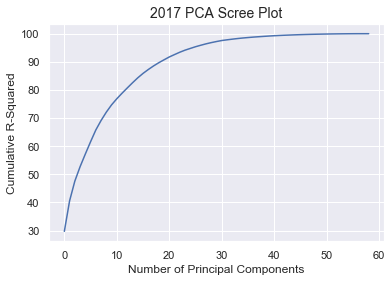

In [181]:
plt.plot(var_2017)
plt.title("2017 PCA Scree Plot", fontsize=14)
plt.xlabel("Number of Principal Components")
plt.ylabel("Cumulative R-Squared")
plt.savefig('pca_2017_scree_plot.png', bbox_inches='tight')

In [182]:
pca_2017 = PCA(n_components = 40) 
principal_2017 = pd.DataFrame(pca_2017.fit_transform(scaled_2017))

In [183]:
components_2017 = pd.DataFrame(pca_2017.components_, columns = pca_clust_2017.columns, index=principal_2017.columns)
components_2017.transpose()


,0,1,2,3,4,5,6,7,8,9,...,30,31,32,33,34,35,36,37,38,39
Access to electricity (% of population),-0.167704,0.214233,-0.126528,-0.111432,-0.001940,0.059205,-0.000287,0.080635,0.018356,-0.060074,...,-0.048176,0.003509,0.061429,0.014569,-0.120007,0.177506,0.099231,-0.075626,0.154986,-0.123949
"Access to electricity, rural (% of rural population)",-0.170604,0.210579,-0.122239,-0.094493,0.010152,0.047000,-0.003655,0.094850,0.042144,-0.037328,...,-0.003561,-0.130411,0.042409,-0.157824,-0.156062,0.326101,0.094770,-0.148035,0.123017,-0.452927
"Access to electricity, urban (% of urban population)",-0.147841,0.195626,-0.117961,-0.101249,-0.021915,0.072605,-0.018992,0.085573,0.059691,-0.052537,...,-0.182933,0.162742,0.011773,0.203815,-0.131201,-0.146745,-0.090973,0.025035,-0.111901,0.305817
Adjusted savings: carbon dioxide damage (current US$),-0.023666,0.164426,0.384755,-0.049159,0.148868,0.007205,-0.136033,0.063627,0.021590,-0.027778,...,-0.117796,0.045849,0.072891,-0.080506,0.106006,0.218324,-0.316946,-0.027382,-0.045250,0.025998
Adjusted savings: energy depletion (current US$),-0.002679,0.197444,0.268796,-0.050517,0.097727,0.009300,-0.011873,0.007530,0.062565,-0.030089,...,0.091903,0.023943,0.138048,0.084327,-0.055263,-0.003100,-0.259889,-0.027863,-0.099558,-0.045224
Adjusted savings: mineral depletion (current US$),-0.029888,0.112762,0.329055,-0.081150,0.082075,0.047062,-0.072606,0.074457,-0.057897,0.023920,...,-0.000352,-0.026838,0.028801,-0.061353,-0.090628,-0.029962,0.078137,-0.026338,0.023797,0.018140
"Birth rate, crude (per 1,000 people)",0.200049,-0.151094,0.073437,0.043372,-0.045086,0.015554,0.004225,-0.034709,-0.025446,-0.029873,...,-0.035773,-0.125914,0.014658,0.008349,0.000206,0.247354,0.116560,0.108570,-0.078721,0.017492
"Death rate, crude (per 1,000 people)",-0.027815,-0.142839,0.012151,0.064555,0.388174,-0.104590,-0.061294,-0.018141,-0.174126,0.083031,...,0.035891,0.070075,-0.081566,-0.105652,-0.017170,0.227023,-0.145746,0.000159,-0.093534,-0.011061
Energy intensity level of primary energy (MJ/$2011 PPP GDP),0.085537,-0.059436,0.040480,0.032075,0.094751,-0.062708,-0.040482,0.116951,0.147359,0.491853,...,0.065122,-0.001551,0.081095,-0.078821,-0.028847,0.045232,0.081324,0.003272,-0.140135,0.083825
"Fertility rate, total (births per woman)",0.189172,-0.160756,0.086513,0.074095,-0.035875,-0.024923,0.007369,-0.057020,-0.040789,-0.019217,...,-0.032399,-0.091558,-0.003230,-0.032867,0.090691,0.437061,0.075160,0.089034,-0.140199,-0.047819


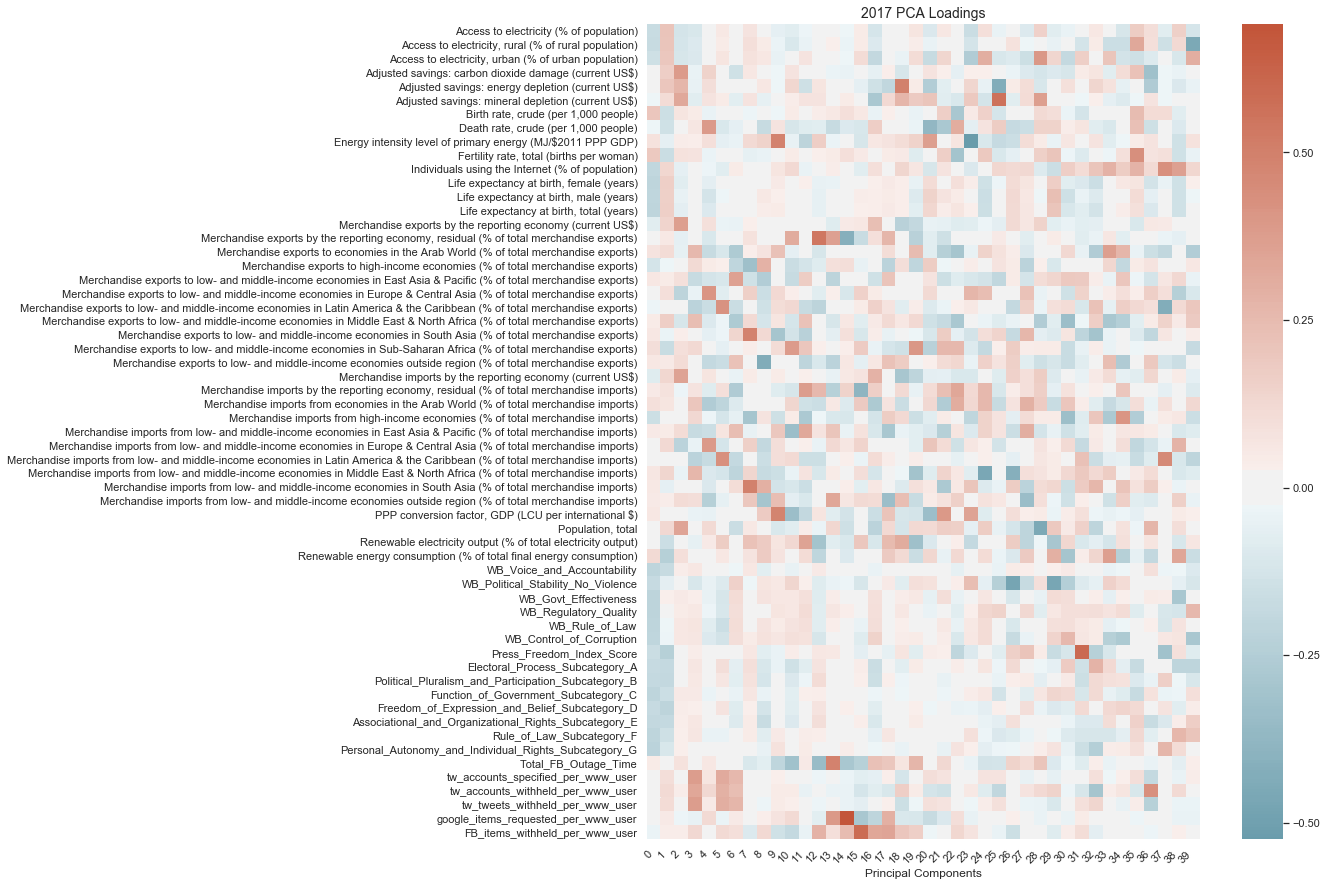

In [184]:
fig, ax = plt.subplots(figsize =(15, 15))

sns.heatmap(
    components_2017.transpose(), 
    #vmin=-1e-8, vmax=1e-8, 
    center=0,
    cmap= sns.diverging_palette(220,20, n=300),#"RdBu_r", 25),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
)
plt.xlabel('Principal Components', fontsize=12)

plt.title('2017 PCA Loadings', fontsize=14)

plt.savefig('pca_2017_loadings_heatmap.png', bbox_inches='tight')

plt.show()

In [185]:
components_2017.iloc[3,:].sort_values(ascending=False).head(10)

tw_accounts_specified_per_www_user                                                                                          0.381015
tw_tweets_withheld_per_www_user                                                                                             0.380595
tw_accounts_withheld_per_www_user                                                                                           0.338843
Merchandise imports from low- and middle-income economies in Middle East & North Africa (% of total merchandise imports)    0.267001
Merchandise exports to economies in the Arab World (% of total merchandise exports)                                         0.260046
Merchandise exports to low- and middle-income economies in Middle East & North Africa (% of total merchandise exports)      0.244141
Merchandise imports from economies in the Arab World (% of total merchandise imports)                                       0.201686
Merchandise imports from high-income economies (% of total merchandis

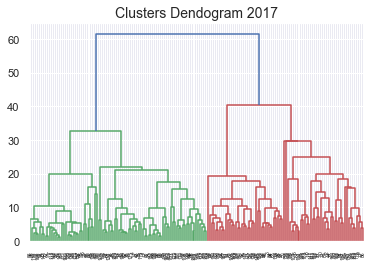

In [194]:
#dendogram; the maximum vertical distance between tree nodes should approximate the optimum number of clusters
fig, ax = plt.subplots()#figsize =(10, 10))
plt.title('Clusters Dendogram 2017', fontsize = 14) 
Dendrogram = shc.dendrogram((shc.linkage(principal_2017, method ='ward'))) 
plt.show()

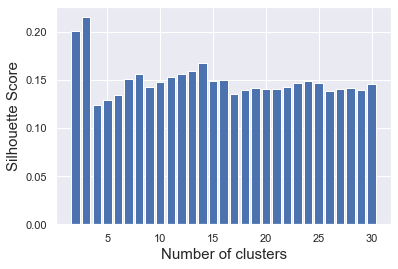

In [199]:
#Silhouette scores; higher score means more similarity within clusters and more dissimilarity to other clusters
clusters = list(range(2,31))
silhouette_scores_2017 = []

for k in clusters:
    ac = AgglomerativeClustering(n_clusters = k, linkage="ward",affinity="euclidean") 
    silhouette_scores_2017.append(silhouette_score(principal_2017, ac.fit_predict(principal_2017)))
    
fig, ax = plt.subplots()
plt.bar(clusters, silhouette_scores_2017) 
#plt.xlim(1,22)
plt.xlabel('Number of clusters', fontsize = 15) 
plt.ylabel('Silhouette Score', fontsize = 15) 
plt.show()

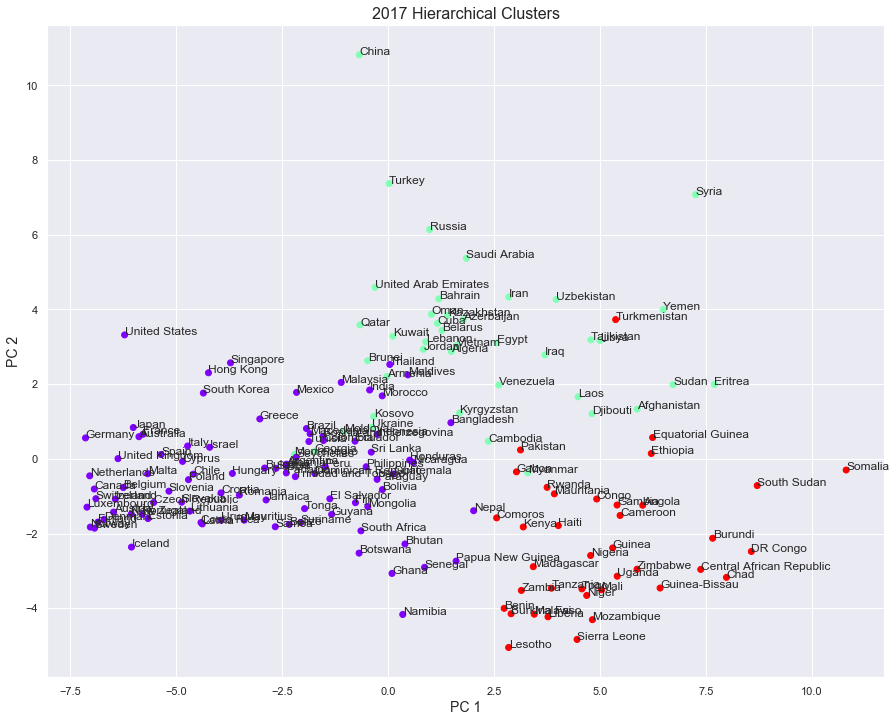

In [200]:
#choose number of clusters

agg_2017 = AgglomerativeClustering(n_clusters = 3, linkage="ward",affinity="euclidean") 
  
fig, ax = plt.subplots(figsize =(15, 12))
x = principal_2017.iloc[:,0] #1st principal component; highest R-squared
y = principal_2017.iloc[:,1] #2nd principal component; 2nd highest R-squared
clust_2017 = agg_2017.fit_predict(principal_2017)
plt.scatter(x, y, c = clust_2017, cmap ='rainbow', label=clust_2017) 

ax.set_xlabel('PC 1', size=14)
ax.set_ylabel('PC 2', size=14)
plt.title('2017 Hierarchical Clusters', fontsize = 16) 

countries_2017 = list(pca_clust_2017.reset_index()['Country_Match'])

for i, country in enumerate(countries_2017):
    ax.annotate(country, (x[i], y[i]))
    
    #for i, year in enumerate(years):
        #ax.annotate(year, (x[i], y[i]))
plt.savefig('pca_2016_v1.png', bbox_inches='tight')
    
plt.show() 


In [201]:
pca_clust_2017['cluster'] = clust_2017

In [234]:
silhouette_score(principal_2017, agg_2018.fit_predict(principal_2017))

0.21522529636470258

## 2018

In [203]:
pca_clust_2018 = data_clust_2018

#pca_clust_2018['FB_withheld_per_www_user'] = pca_clust_2018['FB_Withheld_Count']/pca_clust_2018['Est_Internet_Users']
#pca_clust_2018['tw_accounts_withheld_per_www_user'] = pca_clust_2018['tw_accounts_withheld']/pca_clust_2018['Est_Internet_Users']
#pca_clust_2018 = pca_clust_2018.iloc[:,30:]

pca_clust_2018 = pca_clust_2018.drop([#'Fixed telephone subscriptions','Mobile cellular subscriptions','Rural population','Secure Internet servers','Urban population',
                        'Est_Internet_Users','FB_Withheld_Count','Google_Items_Requested_for_Removal','tw_accounts_specified', 'tw_accounts_tos', 'tw_accounts_withheld','tw_tweets_withheld',], axis=1)


In [204]:
scaler = StandardScaler()
scaled_2018 = scaler.fit_transform(pca_clust_2018)

In [205]:
#pca_clust_2018.columns

In [206]:
pca_clust_2018.shape

(169, 59)

In [207]:
#PCA for dimensionality reduction
#Choose number of principal compnents to use

pca_2018 = PCA(n_components = 59) 
principal_2018 = pd.DataFrame(pca_2018.fit_transform(scaled_2018))#,columns=['P1','P2','P3','P4','P5']) #, 'P6','P7','P8'])
print('Percent of variance explained by the principal components: ' + str(pca_2018.explained_variance_ratio_))
print('Overall R-squared: ' + str(sum(pca_2018.explained_variance_ratio_)))
var_2018 = np.cumsum((pca_2018.explained_variance_ratio_)*100)


Percent of variance explained by the principal components: [2.97980496e-01 1.09355477e-01 7.14083376e-02 4.85134919e-02
 4.56712135e-02 4.13431924e-02 3.58860649e-02 3.23915906e-02
 2.96047645e-02 2.63290262e-02 2.40281046e-02 2.15884810e-02
 2.02816209e-02 1.92169402e-02 1.71029692e-02 1.64082522e-02
 1.38253571e-02 1.24476122e-02 1.10219799e-02 1.04934414e-02
 1.02362043e-02 8.84568751e-03 8.53795095e-03 7.07458925e-03
 6.88344230e-03 5.88242986e-03 5.33911064e-03 4.75167034e-03
 3.98505855e-03 3.70326358e-03 3.52281049e-03 3.02825007e-03
 2.90907243e-03 2.15588722e-03 2.14436270e-03 1.85946936e-03
 1.74496137e-03 1.58870989e-03 1.40909151e-03 1.24949351e-03
 1.11377219e-03 9.93920493e-04 7.69379943e-04 7.02514853e-04
 6.84704116e-04 6.42879517e-04 6.08599404e-04 4.56310699e-04
 3.89459135e-04 3.67269515e-04 3.12939415e-04 3.02804652e-04
 2.44524130e-04 2.34076273e-04 2.07075344e-04 1.36267205e-04
 8.25978353e-05 6.05574676e-07 3.70353098e-07]
Overall R-squared: 0.9999999999999999


In [208]:
print(var_2018)

[ 29.79804963  40.73359731  47.87443107  52.72578026  57.2929016
  61.42722085  65.01582734  68.2549864   71.21546285  73.84836547
  76.25117593  78.41002403  80.43818613  82.35988015  84.07017707
  85.71100229  87.093538    88.33829922  89.44049721  90.48984135
  91.51346178  92.39803053  93.25182563  93.95928455  94.64762878
  95.23587177  95.76978283  96.24494987  96.64345572  97.01378208
  97.36606313  97.66888814  97.95979538  98.1753841   98.38982037
  98.57576731  98.75026344  98.90913443  99.05004358  99.17499294
  99.28637015  99.3857622   99.4627002   99.53295168  99.60142209
  99.66571005  99.72656999  99.77220106  99.81114697  99.84787392
  99.87916786  99.90944833  99.93390074  99.95730837  99.9780159
  99.99164262  99.99990241  99.99996296 100.        ]


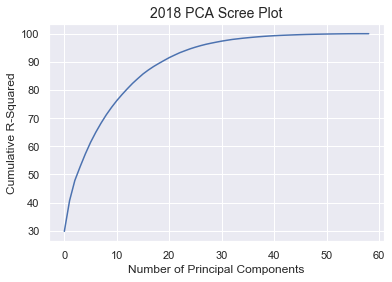

In [209]:
plt.plot(var_2018) #9
plt.title("2018 PCA Scree Plot", fontsize=14)
plt.xlabel("Number of Principal Components")
plt.ylabel("Cumulative R-Squared")
plt.savefig('pca_2018_scree_plot.png', bbox_inches='tight')

In [210]:
pca_2018 = PCA(n_components = 40) 
principal_2018 = pd.DataFrame(pca_2018.fit_transform(scaled_2018))

In [211]:
components_2018 = pd.DataFrame(pca_2018.components_, columns = pca_clust_2018.columns, 
                               index=principal_2018.columns)

In [212]:
components_2018.transpose()

,0,1,2,3,4,5,6,7,8,9,...,30,31,32,33,34,35,36,37,38,39
Access to electricity (% of population),-0.173025,0.205045,-0.136707,-0.084974,0.050676,0.023261,0.001521,0.081115,-0.011318,-0.067073,...,0.041507,0.034811,0.004692,0.015314,-0.053439,-0.178090,-0.037332,0.140287,0.095901,0.161385
"Access to electricity, rural (% of rural population)",-0.176678,0.201862,-0.130348,-0.069918,0.021884,0.013920,0.008873,0.094497,0.016071,-0.057035,...,0.041499,0.032051,-0.060478,0.083545,0.077014,-0.313649,-0.276198,0.123450,0.141883,0.360684
"Access to electricity, urban (% of urban population)",-0.152189,0.192448,-0.130786,-0.082218,0.070533,0.050825,0.017667,0.060662,0.028934,-0.084273,...,-0.090038,-0.063153,0.092594,0.020918,-0.324370,0.071775,0.131198,0.015597,-0.178697,-0.265304
Adjusted savings: carbon dioxide damage (current US$),-0.025912,0.181012,0.379196,-0.133678,-0.094368,0.049248,-0.012953,0.069865,0.041764,-0.012517,...,0.120485,0.076310,0.044565,-0.034677,0.094532,0.038578,-0.073676,0.178087,-0.124080,-0.078662
Adjusted savings: energy depletion (current US$),-0.003056,0.219655,0.260464,-0.088759,-0.047557,-0.029623,0.104259,-0.053860,0.019368,-0.015337,...,-0.095988,0.467421,-0.262325,0.033893,-0.197536,0.086796,-0.091991,-0.196761,-0.038964,-0.145247
Adjusted savings: mineral depletion (current US$),-0.025606,0.140050,0.337802,-0.141764,-0.026349,0.036893,-0.027686,0.079071,0.023769,0.026963,...,-0.185170,-0.205399,-0.036640,0.023965,0.030038,-0.086334,0.053758,0.012737,-0.009124,0.054093
"Birth rate, crude (per 1,000 people)",0.200414,-0.147287,0.077060,0.042403,0.022518,0.018537,-0.004633,-0.036755,-0.049457,0.006675,...,-0.028629,-0.079890,-0.073460,0.042067,-0.068556,-0.047761,-0.161801,0.030022,0.196873,0.019999
"Death rate, crude (per 1,000 people)",-0.037163,-0.131903,0.029331,-0.159408,-0.359961,-0.129855,-0.006531,0.000513,-0.157476,0.142173,...,-0.131053,0.035055,0.032298,0.089479,-0.013531,0.074954,-0.290696,0.031660,0.064282,-0.073061
Energy intensity level of primary energy (MJ/$2011 PPP GDP),0.084469,-0.052971,0.043324,-0.010958,-0.121888,-0.028518,0.027035,0.096582,0.305716,0.372911,...,-0.041872,0.050004,-0.064882,0.047511,0.032126,-0.137372,0.019051,-0.032795,0.068219,-0.126328
"Fertility rate, total (births per woman)",0.189343,-0.154044,0.093357,0.070587,-0.013405,0.000347,-0.026382,-0.053579,-0.067204,0.021158,...,-0.126087,-0.062146,-0.068985,-0.000135,-0.056810,-0.010524,-0.381241,0.043594,0.243689,0.071682


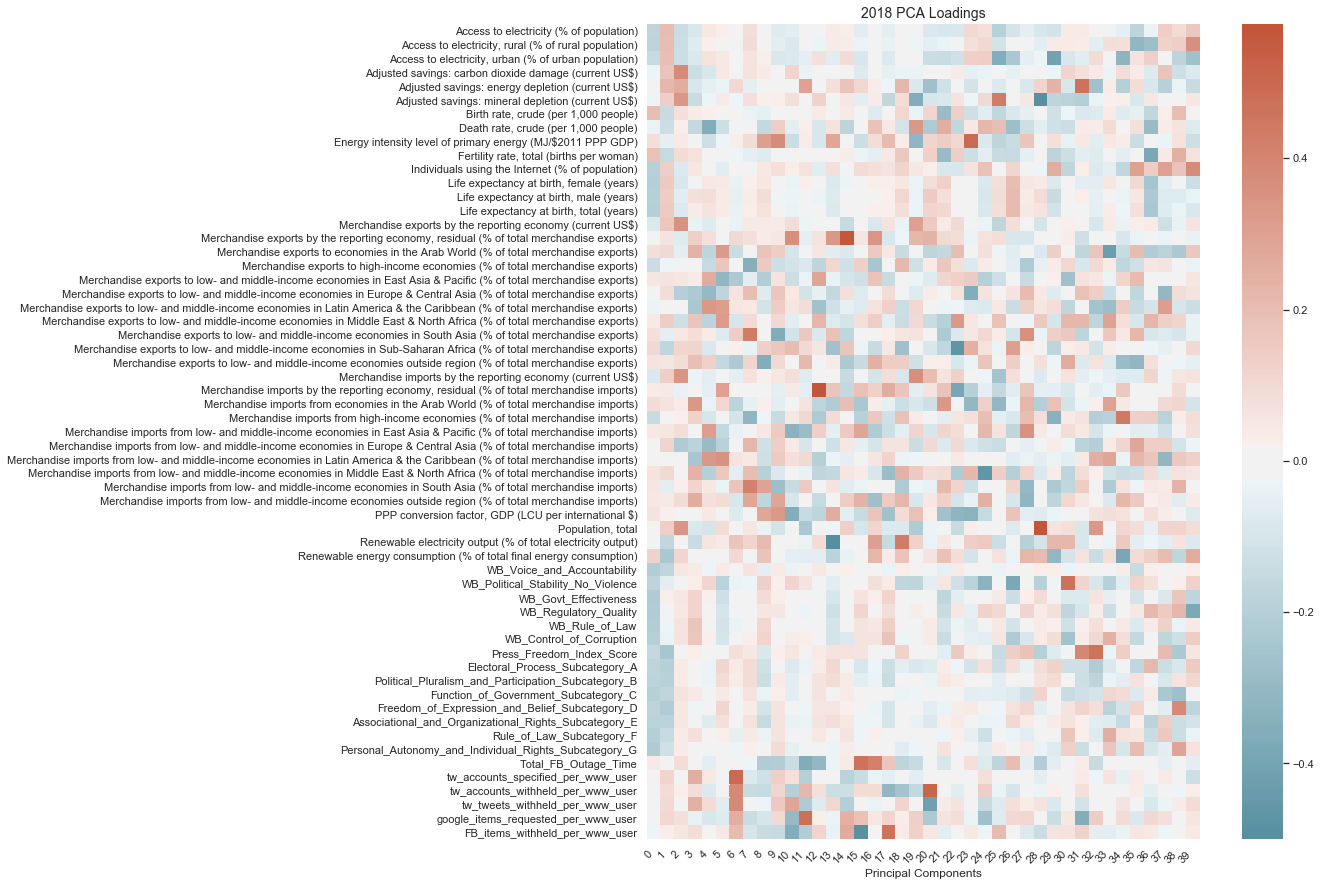

In [214]:
fig, ax = plt.subplots(figsize =(15, 15))

sns.heatmap(
    components_2018.transpose(), 
    #vmin=-1e-8, vmax=1e-8, 
    center=0,
    cmap= sns.diverging_palette(220,20, n=300),#"RdBu_r", 25),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
)
plt.xlabel('Principal Components', fontsize=12)

plt.title('2018 PCA Loadings', fontsize=14)

plt.savefig('pca_2018_loadingd_heatmap.png', bbox_inches='tight')

plt.show()

In [236]:
pc1 = pd.DataFrame(components_2018.iloc[0,:].abs().sort_values(ascending=False).head(10))
pc1.columns = ['2018 PC1 Loadings']
pc1

,2018 PC1 Loadings
Personal_Autonomy_and_Individual_Rights_Subcategory_G,0.217528
WB_Govt_Effectiveness,0.214632
WB_Regulatory_Quality,0.212616
WB_Rule_of_Law,0.209127
WB_Voice_and_Accountability,0.208010
Rule_of_Law_Subcategory_F,0.205527
"Life expectancy at birth, total (years)",0.203885
"Life expectancy at birth, female (years)",0.203607
Function_of_Government_Subcategory_C,0.201045
WB_Control_of_Corruption,0.200612


In [216]:
pc2 = pd.DataFrame(components_2018.iloc[1,:].abs().sort_values(ascending=False).head(10))
pc2.columns = ['2018 PC2 Loadings']
pc2

,2018 PC2 Loadings
Press_Freedom_Index_Score,0.241425
Renewable energy consumption (% of total final energy consumption),0.236391
Adjusted savings: energy depletion (current US$),0.219655
Freedom_of_Expression_and_Belief_Subcategory_D,0.212909
Access to electricity (% of population),0.205045
"Access to electricity, rural (% of rural population)",0.201862
Electoral_Process_Subcategory_A,0.199646
Political_Pluralism_and_Participation_Subcategory_B,0.195892
"Access to electricity, urban (% of urban population)",0.192448
Associational_and_Organizational_Rights_Subcategory_E,0.186012


In [237]:
pc7 = pd.DataFrame(components_2018.iloc[6,:].abs().sort_values(ascending=False).head(10))
pc7.columns = ['2018 PC7 Loadings']
pc7

,2018 PC7 Loadings
tw_accounts_specified_per_www_user,0.496491
tw_accounts_withheld_per_www_user,0.385598
tw_tweets_withheld_per_www_user,0.383067
google_items_requested_per_www_user,0.254961
Merchandise exports to low- and middle-income economies outside region (% of total merchandise exports),0.230779
Merchandise exports to low- and middle-income economies in East Asia & Pacific (% of total merchandise exports),0.226526
FB_items_withheld_per_www_user,0.207754
Merchandise imports from economies in the Arab World (% of total merchandise imports),0.180801
Merchandise imports from low- and middle-income economies in South Asia (% of total merchandise imports),0.177367
Renewable electricity output (% of total electricity output),0.173620


In [240]:
pc12 = pd.DataFrame(components_2018.iloc[11,:].abs().sort_values(ascending=False).head(10))
pc12.columns = ['2018 PC12 Loadings']
pc12

,2018 PC12 Loadings
google_items_requested_per_www_user,0.477553
Total_FB_Outage_Time,0.369226
Adjusted savings: energy depletion (current US$),0.298784
Merchandise imports from low- and middle-income economies in East Asia & Pacific (% of total merchandise imports),0.284764
"Population, total",0.238606
tw_tweets_withheld_per_www_user,0.220077
tw_accounts_withheld_per_www_user,0.215659
Merchandise exports to low- and middle-income economies outside region (% of total merchandise exports),0.212206
FB_items_withheld_per_www_user,0.209749
tw_accounts_specified_per_www_user,0.199616


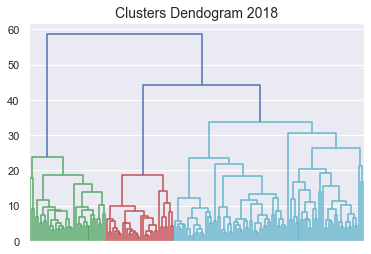

In [220]:
#dendogram; the maximum vertical distance between tree nodes should approximate the optimum number of clusters
fig, ax = plt.subplots()#figsize =(15, 10))#figsize =(10, 10))
plt.title('Clusters Dendogram 2018', fontsize = 14) 
Dendrogram = shc.dendrogram((shc.linkage(principal_2018, method ='ward'))) 
plt.xticks([])
plt.savefig('pca_2018_dendogram.png', bbox_inches='tight')
plt.show()

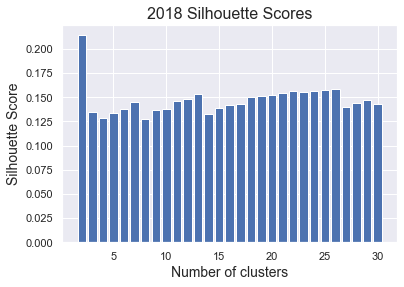

In [241]:
#Silhouette scores; higher score means more similarity within clusters and more dissimilarity to other clusters
clusters = list(range(2,31))
silhouette_scores_2018 = []

for k in clusters:
    ac = AgglomerativeClustering(n_clusters = k, linkage="ward",affinity="euclidean") 
    silhouette_scores_2018.append(silhouette_score(principal_2018, ac.fit_predict(principal_2018)))
    
fig, ax = plt.subplots()
plt.bar(clusters, silhouette_scores_2018) 
#plt.xlim(1,22)
plt.xlabel('Number of clusters', fontsize = 14) 
plt.ylabel('Silhouette Score', fontsize = 14) 
plt.title('2018 Silhouette Scores', fontsize = 16) 
plt.savefig('pca_2018_silhouette_scores.png', bbox_inches='tight')
plt.show()

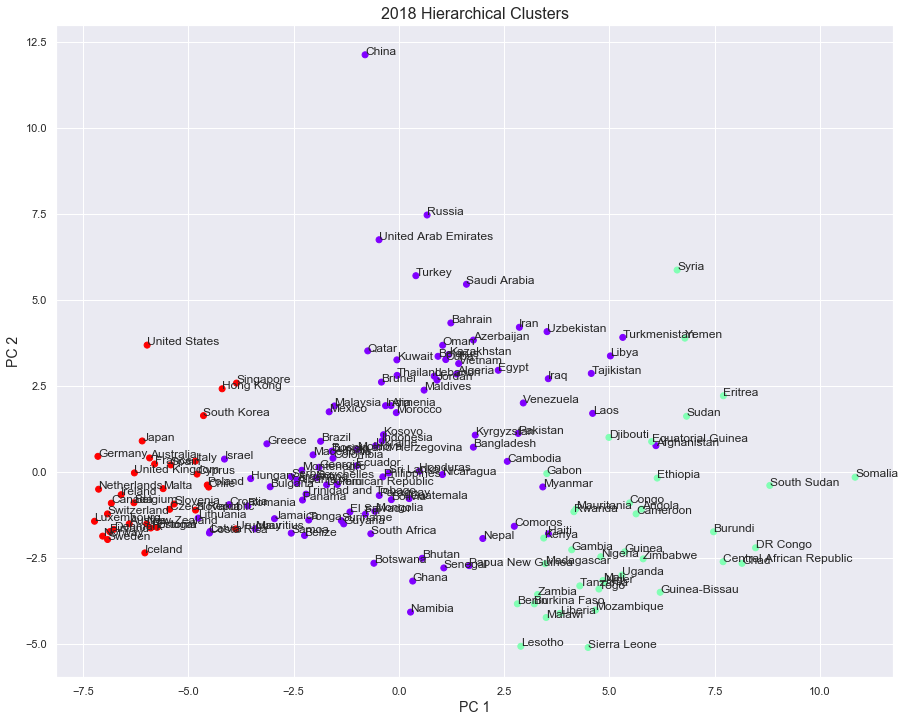

In [250]:
#choose number of clusters

agg_2018 = AgglomerativeClustering(n_clusters = 3, linkage="ward",affinity="euclidean")
  
fig, ax = plt.subplots(figsize =(15, 12))
x = principal_2018.iloc[:,0] #1st principal component; highest R-squared
y = principal_2018.iloc[:,1]
clust_2018 = agg_2018.fit_predict(principal_2018)
plt.scatter(x, y, c = clust_2018, cmap ='rainbow', label=clust_2018) 
#plt.xlim(0.000, 0.001)

#ax.xlim(0.000, 0.001)

ax.set_xlabel('PC 1', size=14)
ax.set_ylabel('PC 2', size=14)
plt.title('2018 Hierarchical Clusters', fontsize = 16) 

countries_2018 = list(pca_clust_2018.reset_index()['Country_Match'])
    #years = list(df_c.reset_index()['Year'])

for i, country in enumerate(countries_2018):
    ax.annotate(country, (x[i], y[i]))
    
    #for i, year in enumerate(years):
        #ax.annotate(year, (x[i], y[i]))
plt.savefig('pca_2018_v3.png', bbox_inches='tight')
    
plt.show() 
    
#pca_clust_2018['cluster'] = clust_2018


In [229]:
silhouette_score(principal_2018, agg_2018.fit_predict(principal_2018))

0.13504351750667362

In [224]:
pca_clust_2018['cluster'] = clust_2018

In [291]:
#Cluster 1
pca_clust_2018[pca_clust_2018['cluster']==0].reset_index().Country_Match[90:96]

90            Turkmenistan
91                 Ukraine
92    United Arab Emirates
93              Uzbekistan
94               Venezuela
95                 Vietnam
Name: Country_Match, dtype: object

In [260]:
#Cluster 2
pca_clust_2018[pca_clust_2018['cluster']==1].reset_index().Country_Match

0                       Angola
1                        Benin
2                 Burkina Faso
3                      Burundi
4                     Cameroon
5     Central African Republic
6                         Chad
7                     DR Congo
8                        Congo
9                     Djibouti
10           Equatorial Guinea
11                     Eritrea
12                    Ethiopia
13                       Gabon
14                      Gambia
15                      Guinea
16               Guinea-Bissau
17                       Kenya
18                     Lesotho
19                     Liberia
20                  Madagascar
21                      Malawi
22                        Mali
23                  Mauritania
24                  Mozambique
25                       Niger
26                     Nigeria
27                      Rwanda
28                Sierra Leone
29                     Somalia
30                 South Sudan
31                       Sudan
32      

In [261]:
#Cluster 3
pca_clust_2018[pca_clust_2018['cluster']==2].reset_index().Country_Match

0          Australia
1            Austria
2            Belgium
3             Canada
4              Chile
5             Cyprus
6     Czech Republic
7            Denmark
8            Estonia
9            Finland
10            France
11           Germany
12         Hong Kong
13           Iceland
14           Ireland
15             Italy
16             Japan
17       South Korea
18        Luxembourg
19             Malta
20       Netherlands
21       New Zealand
22            Norway
23            Poland
24          Portugal
25         Singapore
26          Slovakia
27          Slovenia
28             Spain
29            Sweden
30       Switzerland
31    United Kingdom
32     United States
33           Uruguay
Name: Country_Match, dtype: object

In [232]:
#I had rescaled the score, which is why it is negative, but 
pca_clust_2018.groupby(['cluster']).Press_Freedom_Index_Score.agg('mean')


cluster
0   -37.527396
1   -41.942821
2   -18.843235
Name: Press_Freedom_Index_Score, dtype: float64

In [242]:
pca_clust_2018.groupby(['cluster']).Freedom_of_Expression_and_Belief_Subcategory_D.agg('mean')


cluster
0     9.750000
1     7.615385
2    15.029412
Name: Freedom_of_Expression_and_Belief_Subcategory_D, dtype: float64

In [243]:
#Scale of -2.5 to 2.5, with higher score meaning freer speech
pca_clust_2018.groupby(['cluster']).WB_Voice_and_Accountability.agg('mean')

cluster
0   -0.293542
1   -0.899744
2    1.210000
Name: WB_Voice_and_Accountability, dtype: float64

In [253]:
pca_clust_2018.groupby(['cluster']).Total_FB_Outage_Time.agg('mean')

cluster
0    258900.000000
1    963046.923077
2         0.000000
Name: Total_FB_Outage_Time, dtype: float64

In [292]:
cluster_means = pca_clust_2018.groupby(['cluster'])[['Press_Freedom_Index_Score','Freedom_of_Expression_and_Belief_Subcategory_D','WB_Voice_and_Accountability','Total_FB_Outage_Time','tw_accounts_specified_per_www_user','tw_accounts_withheld_per_www_user','tw_tweets_withheld_per_www_user','google_items_requested_per_www_user','FB_items_withheld_per_www_user']].agg('mean').round(6).T
cluster_means.columns = ['Purple','Green','Red']
cluster_means

,Purple,Green,Red
Press_Freedom_Index_Score,-37.527396,-41.942821,-18.843235
Freedom_of_Expression_and_Belief_Subcategory_D,9.750000,7.615385,15.029412
WB_Voice_and_Accountability,-0.293542,-0.899744,1.210000
Total_FB_Outage_Time,258900.000000,963046.923077,0.000000
tw_accounts_specified_per_www_user,0.000013,0.000000,0.000004
tw_accounts_withheld_per_www_user,0.000001,0.000000,0.000001
tw_tweets_withheld_per_www_user,0.000006,0.000000,0.000002
google_items_requested_per_www_user,0.000044,0.000002,0.000035
FB_items_withheld_per_www_user,0.000010,0.000000,0.000008


In [277]:
#pca_clust_2018.groupby(['cluster']).tw_tweets_withheld_per_www_user.agg('mean')